In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle

mpl.rc('font',**{'family':'serif','monospace':['Palatino']})
mpl.rc('text', usetex=True)
plt.rcParams['figure.constrained_layout.use'] = False
mpl.rcParams.update({'font.size': 9})

age = 13.800797497330507

In [2]:
def read_timescales():
    '''Function to read in the data file which contains quenching and infall times'''
    data = []
    with open('../../Data/QuenchingTimescales.data', 'rb') as f:
        while True:
            try:
                data.append(pickle.load(f,encoding='latin1'))
            except EOFError:
                break

    data = pd.DataFrame(data)
    return data

## Read in the data

Particle tracking data is stored at `Justice_League_Code/Data/tracked_particles.hdf5`. This HDF5 file format stores multiple tables efficiently and can be easily written to/read into `pandas`. Each galaxy that has been tracked is stored as a table in the HDF5 file under the key `{sim}_{z0haloid}`. For example:

In [3]:
path = '../../Data/tracked_particles.hdf5'
with pd.HDFStore(path) as hdf:
    print('Available keys:', *hdf.keys())

Available keys: /h148_13 /h148_28 /h148_37 /h148_68 /h229_20 /h229_22 /h242_24 /h242_80


We'll use `h242_24` for now. 

In [4]:
key = 'h242_24'
data = pd.read_hdf(path, key=key)

data

,time,pid,rho,temp,mass,coolontime,r,r_per_Rvir,x,y,...,host_Zc,host_vx,host_vy,host_vz,sat_disk,sat_halo,IGM,host_halo,host_disk,classification
0,5.181190,811077,0.000037,5.369499e+05,26510.536704,0.000000,317.229043,12.504154,-173.390813,23.552462,...,11877.577060,98.07,206.77,36.51,False,False,True,False,False,5.0
1,5.181190,6872943,0.000560,1.621470e+06,33820.435130,4.999814,305.111904,12.026535,-149.748558,152.158116,...,11877.577060,98.07,206.77,36.51,False,False,False,True,False,4.0
2,5.181190,8840402,0.000179,6.317682e+04,26510.536704,0.000000,352.882340,13.909492,133.276947,199.077824,...,11877.577060,98.07,206.77,36.51,False,False,True,False,False,5.0
3,5.181190,8987571,0.000017,2.664518e+05,26510.536704,0.000000,26.778647,1.055529,-9.585453,-3.929157,...,11877.577060,98.07,206.77,36.51,False,False,True,False,False,5.0
4,5.181190,9655109,0.000078,1.011527e+05,26510.536704,0.000000,16.040076,0.632248,-2.434631,-11.577726,...,11877.577060,98.07,206.77,36.51,False,True,True,False,False,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10476,13.800797,10503018,0.000018,2.953280e+05,26510.548793,0.000000,361.417481,7.212325,-312.938541,80.286533,...,26386.031647,107.68,154.11,21.47,False,False,False,True,False,4.0
10477,13.800797,10503024,0.000081,8.588152e+05,26520.522274,0.000000,240.255195,4.794451,-48.069470,61.066270,...,26386.031647,107.68,154.11,21.47,False,False,False,True,False,4.0
10478,13.800797,10503746,0.000117,1.134624e+06,26659.904046,5.228853,271.157246,5.411122,-121.951103,67.224175,...,26386.031647,107.68,154.11,21.47,False,False,False,True,False,4.0
10479,13.800797,10505840,0.000022,4.070112e+05,27619.316654,7.211029,267.735199,5.342833,14.907680,90.504259,...,26386.031647,107.68,154.11,21.47,False,False,False,True,False,4.0


## Basic plots of satellite orbit and particle paths

Plot the satellite orbit in $x-y$ and in $x-z$, and plot the paths of a random sample of $N$ tracked particles. 

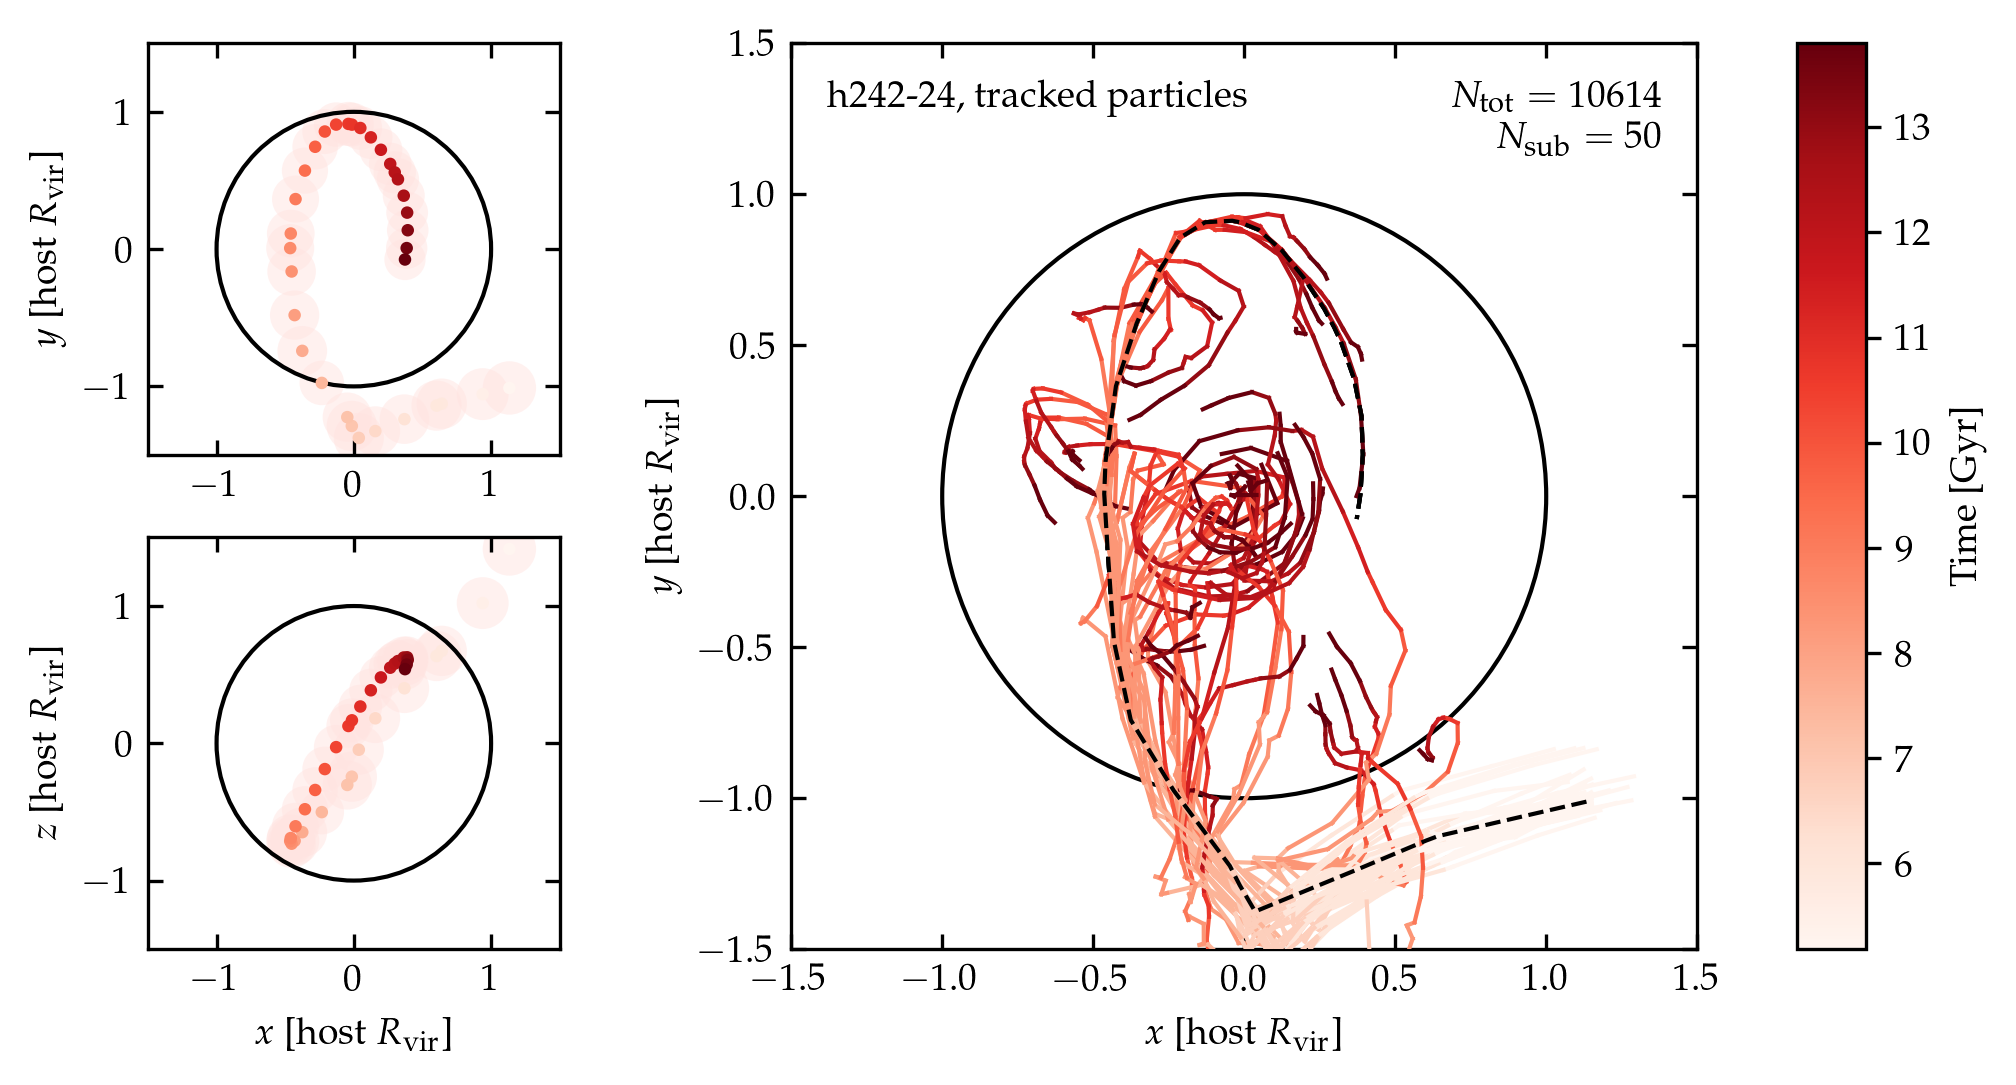

In [54]:
R = 1.5 # in Rvir, the maximum radius to plot 
N = 50 # number of particles to select in subsample

fig = plt.figure(dpi=300, figsize=(7.5,4))
gs = mpl.gridspec.GridSpec(2,5, width_ratios = [1,0.1,1,1,0.15], figure=fig)
ax0 = plt.subplot(gs[0,0])
ax1 = plt.subplot(gs[1,0])
ax2 = plt.subplot(gs[0:,2:-1])
cbax = plt.subplot(gs[:,-1])

host_radius = plt.Circle((0, 0), 1, color='k', fill=False)
ax0.add_artist(host_radius)

host_radius = plt.Circle((0, 0), 1, color='k', fill=False)
ax1.add_artist(host_radius)

host_radius = plt.Circle((0, 0), 1, color='k', fill=False)
ax2.add_artist(host_radius)

x_rel, y_rel, z_rel, Rvirs, ts = np.array([]),np.array([]),np.array([]),np.array([]),np.array([])
for t in np.unique(data.time):
    d = data[data.time==t]
    sat_x, sat_y, sat_z = np.mean(d.sat_Xc), np.mean(d.sat_Yc), np.mean(d.sat_Zc)
    host_x, host_y, host_z = np.mean(d.host_Xc), np.mean(d.host_Yc), np.mean(d.host_Zc)
    
    h1Rvir = np.mean(d.h1Rvir)
    satRvir = np.mean(d.satRvir)
    
    x_rel = np.append(x_rel, (sat_x-host_x)/h1Rvir)
    y_rel = np.append(y_rel, (sat_y-host_y)/h1Rvir)
    z_rel = np.append(z_rel, (sat_z-host_z)/h1Rvir)
    
    Rvirs = np.append(Rvirs, satRvir/h1Rvir*1100)
    
    radii = plt.Circle(((sat_x-host_x)/h1Rvir,(sat_y-host_y)/h1Rvir),
                     satRvir/h1Rvir, ec='none',fc='mistyrose', alpha=0.5, fill=True, zorder=0.5)
    ax0.add_artist(radii)
    
    radii = plt.Circle(((sat_x-host_x)/h1Rvir,(sat_z-host_z)/h1Rvir),
                     satRvir/h1Rvir, ec='none',fc='mistyrose', alpha=0.5, fill=True, zorder=0.5)
    ax1.add_artist(radii)
    
    ts = np.append(ts,t)
    
ax0.scatter(x_rel, y_rel, c=ts, cmap='Reds', s=4, zorder=2)
ax1.scatter(x_rel, z_rel, c=ts, cmap='Reds', s=4, zorder=2)
ax2.plot(x_rel, y_rel, 'k--', linewidth=1, zorder=1)
ax2.plot(x_rel, y_rel, 'k--', linewidth=1, zorder=1)
ax2.plot(x_rel, y_rel, 'k--', linewidth=1, zorder=1000)

pids = np.unique(data.pid)
np.random.seed(123)
pids_sub = np.random.choice(pids, size=N)

for j,pid in enumerate(pids_sub):
    d = data[data.pid==pid]
    
    cmap = mpl.cm.get_cmap('Reds', 12)
    tmin, tmax = np.min(d.time), np.max(d.time)
    
    i_prev = 0
    for i in range(len(d)-1):
        i += 1
        h1Rvir = list(d.h1Rvir)[i_prev]
        x1 = list(d.x_rel_host)[i_prev] / h1Rvir
        y1 = list(d.y_rel_host)[i_prev] / h1Rvir
        z1 = list(d.z_rel_host)[i_prev] / h1Rvir
        
        h1Rvir = list(d.h1Rvir)[i]
        x2 = list(d.x_rel_host)[i] / h1Rvir
        y2 = list(d.y_rel_host)[i] / h1Rvir
        z2 = list(d.z_rel_host)[i] / h1Rvir
        t = list(d.time)[i]
        
        c = cmap((t-tmin)/(tmax-tmin))
        ax2.plot([x1,x2],[y1,y2],color=c, linewidth=1, zorder=j)

        i_prev = i
    
cb1 = mpl.colorbar.ColorbarBase(cbax, cmap=mpl.cm.Reds, orientation='vertical', 
                                norm = mpl.colors.Normalize(vmin=tmin, vmax=tmax),
                                label='Time [Gyr]')

ax1.set_xlabel(r'$x$ [host $R_{\rm vir}$]')
ax1.set_ylabel(r'$z$ [host $R_{\rm vir}$]')
ax0.set_ylabel(r'$y$ [host $R_{\rm vir}$]')
ax2.annotate(f"{key.replace('_','-')}, tracked particles", (0.04, 0.96), xycoords='axes fraction', va='top')
ax2.annotate(r'$N_{\rm tot} =$' + fr' ${len(pids)}$'+'\n'+r'$N_{\rm sub} =$' + fr' ${N}$', 
            (0.96, 0.96), xycoords='axes fraction', va='top', ha='right')

ax0.set_xlim(-R,R)
ax0.set_ylim(-R,R)
ax1.set_xlim(-R,R)
ax1.set_ylim(-R,R)
ax2.set_xlim(-R,R)
ax2.set_ylim(-R,R)

ax0.set_aspect('equal')
ax1.set_aspect('equal')
ax2.set_aspect('equal')

ax2.set_xlabel(r'$x$ [host $R_{\rm vir}$]')
ax2.set_ylabel(r'$y$ [host $R_{\rm vir}$]')


ax0.tick_params(top=True,right=True,direction='in', which='both')
ax1.tick_params(top=True,right=True,direction='in', which='both')
ax2.tick_params(top=True,right=True,direction='in', which='both')

# plt.savefig(f'plots/orbits/{key}_orbit.pdf')

plt.show()

## Gas fractions in different states over time.

Plot what fractions of the total gas mass tracked is in different states over time. 

What are the states we want to consider? 

For now, we are studying the location and state the gas particles end up in. It should suffice to define the categories as disk vs. halo, i.e. 

- sat disk
- sat halo
- host halo
- host disk 
- IGM

To do these classifications, we will use the definitions of gravitationally bound vs. unbound to the disk to determine disk vs. halo ownership, and use the virial radius to determine halo vs. IGM/CGM. 
We could also make this more nuanced by including the thermodynamic disk properties, i.e. plotting the fraction of the disk that is hot but still bound. This will definitely come into play in later sections, but may not be worth it for now. 

We need to first define our gravitationally bound disk:

In [6]:
path = '../../Data/ram_pressure.hdf5'
properties = pd.read_hdf(path, key=key)

In [57]:
data = pd.merge(particles, masses, on='time', how='left')

In [59]:

m = np.array(data.mass) * 1.989e30
v = np.array(data.v) * 1000
K = 0.5 * m * v * v

M = np.array(data.M) * 1.989e30
r = np.array(data.r) * 3.086e19
U = 6.6743e-11 * M * m / r

ratio = K/U

data['K'] = K
data['U'] = U
data['ratio'] = ratio

data

,time,pid,rho,temp,mass,coolontime,r,r_per_Rvir,x,y,...,sat_disk,sat_halo,IGM,host_halo,host_disk,classification,M,K,U,ratio
0,5.181190,811077,0.000037,5.369499e+05,26510.536704,0.000000,317.229043,12.504154,-173.390813,23.552462,...,False,False,True,False,False,5.0,2.192864e+08,2.427971e+44,1.567966e+41,1548.484011
1,5.181190,6872943,0.000560,1.621470e+06,33820.435130,4.999814,305.111904,12.026535,-149.748558,152.158116,...,False,False,False,True,False,4.0,2.192864e+08,3.326192e+44,2.079750e+41,1599.322701
2,5.181190,8840402,0.000179,6.317682e+04,26510.536704,0.000000,352.882340,13.909492,133.276947,199.077824,...,False,False,True,False,False,5.0,2.192864e+08,2.793106e+44,1.409548e+41,1981.561877
3,5.181190,8987571,0.000017,2.664518e+05,26510.536704,0.000000,26.778647,1.055529,-9.585453,-3.929157,...,False,False,True,False,False,5.0,2.192864e+08,4.125136e+42,1.857467e+42,2.220840
4,5.181190,9655109,0.000078,1.011527e+05,26510.536704,0.000000,16.040076,0.632248,-2.434631,-11.577726,...,False,True,True,False,False,5.0,2.192864e+08,8.744303e+42,3.101011e+42,2.819824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
349213,13.800797,10503018,0.000018,2.953280e+05,26510.548793,0.000000,361.417481,7.212325,-312.938541,80.286533,...,False,False,False,True,False,4.0,1.365987e+07,6.904967e+44,8.573054e+39,80542.671916
349214,13.800797,10503024,0.000081,8.588152e+05,26520.522274,0.000000,240.255195,4.794451,-48.069470,61.066270,...,False,False,False,True,False,4.0,1.365987e+07,8.507121e+44,1.290135e+40,65939.756973
349215,13.800797,10503746,0.000117,1.134624e+06,26659.904046,5.228853,271.157246,5.411122,-121.951103,67.224175,...,False,False,False,True,False,4.0,1.365987e+07,1.029487e+45,1.149115e+40,89589.620057
349216,13.800797,10505840,0.000022,4.070112e+05,27619.316654,7.211029,267.735199,5.342833,14.907680,90.504259,...,False,False,False,True,False,4.0,1.365987e+07,9.871753e+44,1.205684e+40,81876.794160


In [87]:
thermo_disk = (np.array(data.temp) < 1.2e4) & (np.array(data.rho) > 0.1)
grav_disk = np.array(data.ratio) < 1 
in_satellite = np.array(data.r_per_Rvir) < 1

cool_disk = thermo_disk & grav_disk
hot_disk = ~thermo_disk & grav_disk
cool_halo = thermo_disk & ~grav_disk & in_satellite
hot_halo = ~thermo_disk & ~grav_disk & in_satellite
CGM = ~in_satellite
c = cool_disk + 2*hot_disk + 3*cool_halo + 4*hot_halo + 5*CGM

In [5]:
thermo_disk = (np.array(data.temp) < 1.2e4) & (np.array(data.rho) > 0.1)
spatial_disk = np.array(data.r_per_Rvir) < 0.15 # eventually the "spatial disk" should be defined as more of the "dynamical disk"
in_satellite = np.array(data.r_per_Rvir) < 1

cool_disk = thermo_disk & spatial_disk
hot_disk = ~thermo_disk & spatial_disk
cool_halo = thermo_disk & ~spatial_disk & in_satellite
hot_halo = ~thermo_disk & ~spatial_disk & in_satellite
CGM = ~in_satellite

In [18]:
times = np.unique(data.time)

frac_satdisk = np.array([])
frac_sathalo = np.array([])
frac_hostdisk = np.array([])
frac_hosthalo = np.array([])
frac_IGM = np.array([])

for t in times:
    d = data[data.time==t]
    
    frac_satdisk = np.append(frac_satdisk,np.sum(d.mass[d.sat_disk])/np.sum(d.mass))
    frac_sathalo = np.append(frac_sathalo,np.sum(d.mass[d.sat_halo])/np.sum(d.mass))
    frac_hostdisk = np.append(frac_hostdisk,np.sum(d.mass[d.host_disk])/np.sum(d.mass))
    frac_hosthalo = np.append(frac_hosthalo,np.sum(d.mass[d.host_halo])/np.sum(d.mass))
    frac_IGM = np.append(frac_IGM,np.sum(d.mass[d.IGM])/np.sum(d.mass))

frac_lost = 1 - (frac_satdisk+frac_sathalo+frac_hostdisk+frac_hosthalo+frac_IGM)

timescales = read_timescales()
timescales = timescales[(timescales.sim==key[:4])&(timescales.haloid==int(key[-2:]))]
tinfall = age - timescales.tinfall.tolist()[0]
tquench = age - timescales.tquench.tolist()[0]

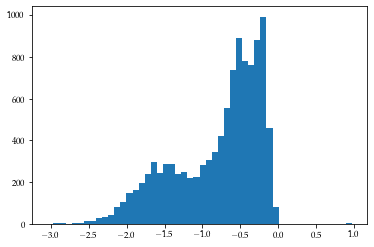

In [28]:
r_per_Rvir = data[data.time == np.min(times)].r_per_Rvir

plt.hist(np.log10(r_per_Rvir*0.67), bins=50)
plt.show()

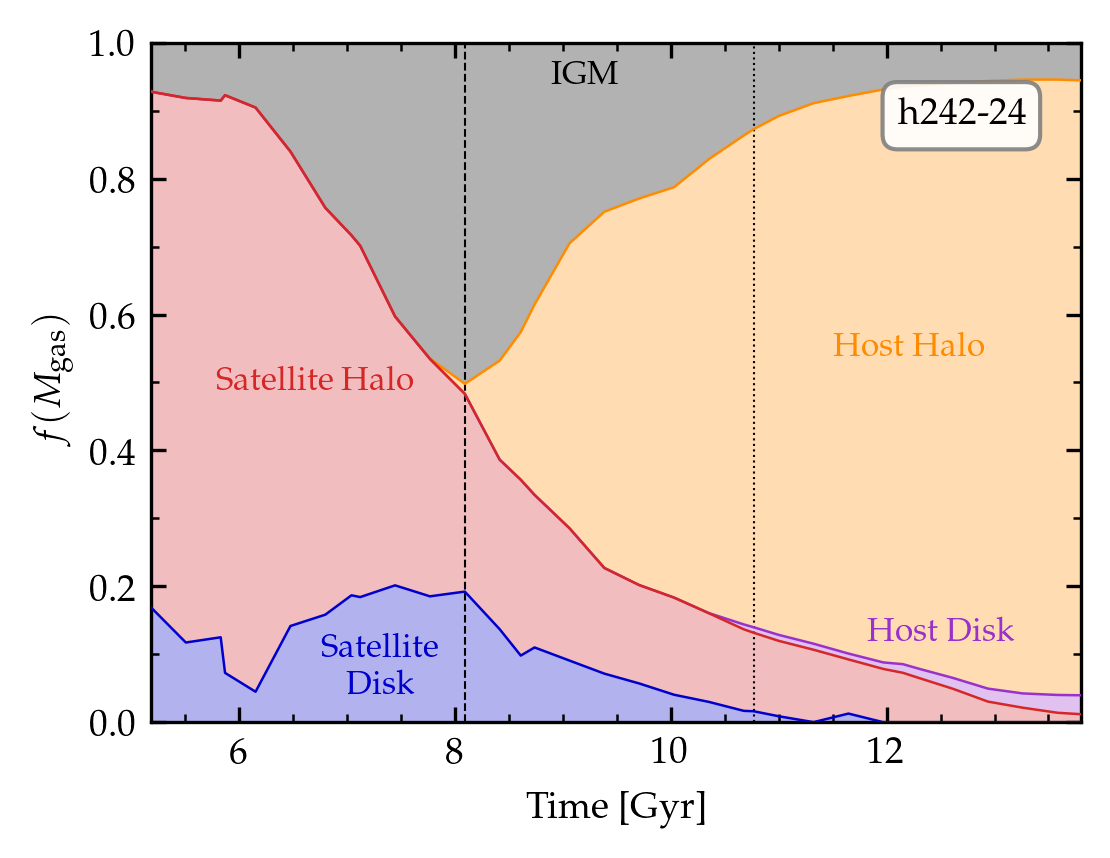

In [19]:
fig, ax = plt.subplots(1,1,dpi=300,figsize=(4,3))

colors = ['mediumblue', 'tab:red', 'darkorchid', 'darkorange', 'k']

lw = 0.6
alpha = 0.3
fontsize = 8

ax.fill_between(times, 0, frac_satdisk,fc=colors[0], alpha=alpha)
ax.plot(times, frac_satdisk, color=colors[0], linewidth=lw, zorder=6)

ax.fill_between(times, frac_satdisk, frac_satdisk+frac_sathalo, fc=colors[1], alpha=alpha)
ax.plot(times, frac_satdisk+frac_sathalo, color=colors[1], linewidth=lw, zorder=5)

ax.fill_between(times, frac_satdisk+frac_sathalo, frac_satdisk+frac_sathalo+frac_hostdisk, fc=colors[2], alpha=alpha)
ax.plot(times, frac_satdisk+frac_sathalo+frac_hostdisk, color=colors[2], linewidth=lw, zorder=4)

ax.fill_between(times, frac_satdisk+frac_sathalo+frac_hostdisk, frac_satdisk+frac_sathalo+frac_hostdisk+frac_hosthalo, fc=colors[3], alpha=alpha)
ax.plot(times, frac_satdisk+frac_sathalo+frac_hostdisk+frac_hosthalo, color=colors[3], linewidth=lw, zorder=3)

ax.fill_between(times, frac_satdisk+frac_sathalo+frac_hostdisk+frac_hosthalo,frac_satdisk+frac_sathalo+frac_hostdisk+frac_hosthalo+frac_IGM, fc=colors[4], alpha=alpha)
ax.plot(times, frac_satdisk+frac_sathalo+frac_hostdisk+frac_hosthalo+frac_IGM, color=colors[4], linewidth=lw, zorder=2)

ax.axline((tinfall,0),(tinfall,1),linestyle='--', linewidth=0.5, color='k')
ax.axline((tquench,0),(tquench,1),linestyle=':', linewidth=0.5, color='k')

ax.set_xlim(min(times),max(times))
ax.set_ylim(0,1)

ax.set_xlabel('Time [Gyr]')
ax.set_ylabel(r'$f(M_{\rm gas})$')

ax.annotate('Satellite \n Disk',(7.3,0.08),ha='center', va='center', color=colors[0], size=fontsize)
ax.annotate('Satellite Halo',(6.7,0.5),ha='center', va='center', color=colors[1], size=fontsize)
ax.annotate('Host Disk',(12.5,0.13),ha='center', va='center', color=colors[2], size=fontsize)
ax.annotate('Host Halo',(12.2,0.55),ha='center', va='center', color=colors[3], size=fontsize)
ax.annotate('IGM',(9.2,0.95),ha='center', va='center', color=colors[4], size=fontsize)

ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.5))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.1))
ax.tick_params(direction='in', which='both', top=True,right=True)

ax.annotate(key.replace('_','-'), (0.94, 0.92), xycoords='axes fraction', ha='right', va='top',
            bbox=dict(boxstyle='round,pad=0.4', fc='w', ec='0.5', alpha=0.9), zorder=100)

# plt.savefig(f'plots/fractions/{key}_fractions.pdf')
plt.show()

In [14]:
def fill_fractions_ax(key, ax, label=False):
    data = pd.read_hdf(path, key=key)
    timescales = read_timescales()

    # temporary
    data = data.rename(columns={'sat_disk': 'sat_disk_wrong', 'host_disk': 'host_disk_wrong',
                                'sat_halo': 'sat_halo_wrong', 'host_halo': 'host_halo_wrong'})

    data['sat_disk'] = (data.rho >= 0.1) & (data.temp <= 1.2e4) & (data.r <= 3)
    data['sat_halo'] = (data.r_per_Rvir < 1) & ~data.sat_disk
    data['host_disk'] = (data.rho >= 0.1) & (data.temp <= 1.2e4) & (data.r_per_Rvir > 1) & (data.h1dist < 0.1)
    data['host_halo'] = (data.r_per_Rvir > 1) & (data.h1dist < 1) & ~data.host_disk

    times = np.unique(data.time)

    frac_satdisk,frac_sathalo,frac_hostdisk,frac_hosthalo,frac_IGM = np.array([]),np.array([]),np.array([]),np.array([]),np.array([])

    for t in times:
        d = data[data.time==t]
        frac_satdisk = np.append(frac_satdisk,np.sum(d.mass[d.sat_disk])/np.sum(d.mass))
        frac_sathalo = np.append(frac_sathalo,np.sum(d.mass[d.sat_halo])/np.sum(d.mass))
        frac_hostdisk = np.append(frac_hostdisk,np.sum(d.mass[d.host_disk])/np.sum(d.mass))
        frac_hosthalo = np.append(frac_hosthalo,np.sum(d.mass[d.host_halo])/np.sum(d.mass))
        frac_IGM = np.append(frac_IGM,np.sum(d.mass[d.IGM])/np.sum(d.mass))

    frac_lost = 1 - (frac_satdisk+frac_sathalo+frac_hostdisk+frac_hosthalo+frac_IGM)


    t = timescales[(timescales.sim==key[:4])&(timescales.haloid==int(key[-2:]))]
    tinfall = age - t.tinfall.tolist()[0]
    tquench = age - t.tquench.tolist()[0]

    lw = 0.6
    alpha = 0.3
    fontsize = 8
    colors = ['mediumblue', 'tab:red', 'darkorchid', 'darkorange', 'k']

    ax.fill_between(times, 0, frac_satdisk,fc=colors[0], alpha=alpha)
    ax.plot(times, frac_satdisk, color=colors[0], linewidth=lw, zorder=6)

    ax.fill_between(times, frac_satdisk, frac_satdisk+frac_sathalo, fc=colors[1], alpha=alpha)
    ax.plot(times, frac_satdisk+frac_sathalo, color=colors[1], linewidth=lw, zorder=5)

    ax.fill_between(times, frac_satdisk+frac_sathalo, frac_satdisk+frac_sathalo+frac_hostdisk, fc=colors[2], alpha=alpha)
    ax.plot(times, frac_satdisk+frac_sathalo+frac_hostdisk, color=colors[2], linewidth=lw, zorder=4)

    ax.fill_between(times, frac_satdisk+frac_sathalo+frac_hostdisk, frac_satdisk+frac_sathalo+frac_hostdisk+frac_hosthalo, fc=colors[3], alpha=alpha)
    ax.plot(times, frac_satdisk+frac_sathalo+frac_hostdisk+frac_hosthalo, color=colors[3], linewidth=lw, zorder=3)

    ax.fill_between(times, frac_satdisk+frac_sathalo+frac_hostdisk+frac_hosthalo,frac_satdisk+frac_sathalo+frac_hostdisk+frac_hosthalo+frac_IGM, fc=colors[4], alpha=alpha)
    ax.plot(times, frac_satdisk+frac_sathalo+frac_hostdisk+frac_hosthalo+frac_IGM, color=colors[4], linewidth=lw, zorder=2)

    ax.axline((tinfall,0),(tinfall,1),linestyle='--', linewidth=0.5, color='k')
    ax.axline((tquench,0),(tquench,1),linestyle=':', linewidth=0.5, color='k')

    ax.set_xlim(min(times),max(times))
    ax.set_ylim(0,1)

    if label:
        if key=='h242_24':
            ax.annotate('Sat \n Disk',(7.3,0.08),ha='center', va='center', color=colors[0], size=fontsize)
            ax.annotate('Sat \n Halo',(6.7,0.5),ha='center', va='center', color=colors[1], size=fontsize)
            ax.annotate('Host \n Disk',(12.5,0.18),ha='center', va='center', color=colors[2], size=fontsize)
            ax.annotate('Host Halo',(12.2,0.55),ha='center', va='center', color=colors[3], size=fontsize)
            ax.annotate('IGM',(9.2,0.95),ha='center', va='center', color=colors[4], size=fontsize)
        if key=='h148_68':
            ax.annotate('Sat \n Disk',(7.3,0.1),ha='center', va='center', color=colors[0], size=fontsize)
            ax.annotate('Sat \n Halo',(7.3,0.53),ha='center', va='center', color=colors[1], size=fontsize)
            ax.annotate('Host \n Disk',(13,0.33),ha='center', va='center', color=colors[2], size=fontsize)
            ax.annotate('Host Halo',(10.8,0.55),ha='center', va='center', color=colors[3], size=fontsize)
            ax.annotate('IGM',(9.2,0.95),ha='center', va='center', color=colors[4], size=fontsize)
    else:
        ax.tick_params(labelleft=False)

    ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.5))
    ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.1))
    ax.tick_params(direction='in', which='both', top=True,right=True)

    ax.annotate(key.replace('_','-'), (0.94, 0.92), xycoords='axes fraction', ha='right', va='top',
                bbox=dict(boxstyle='round,pad=0.4', fc='w', ec='0.5', alpha=0.9), zorder=100)

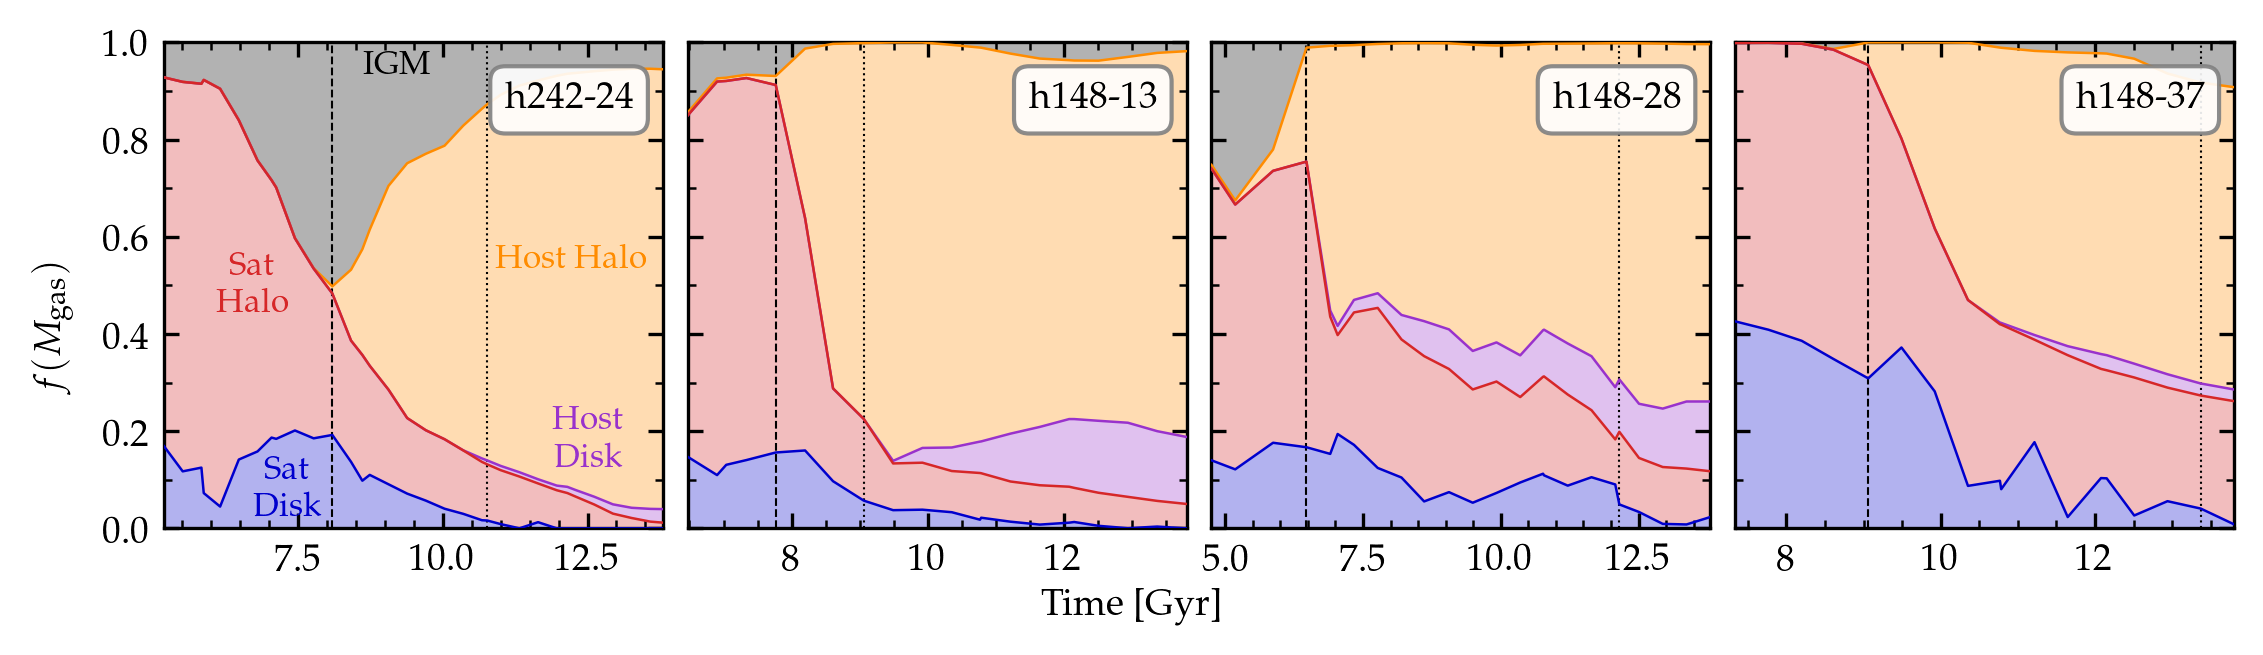

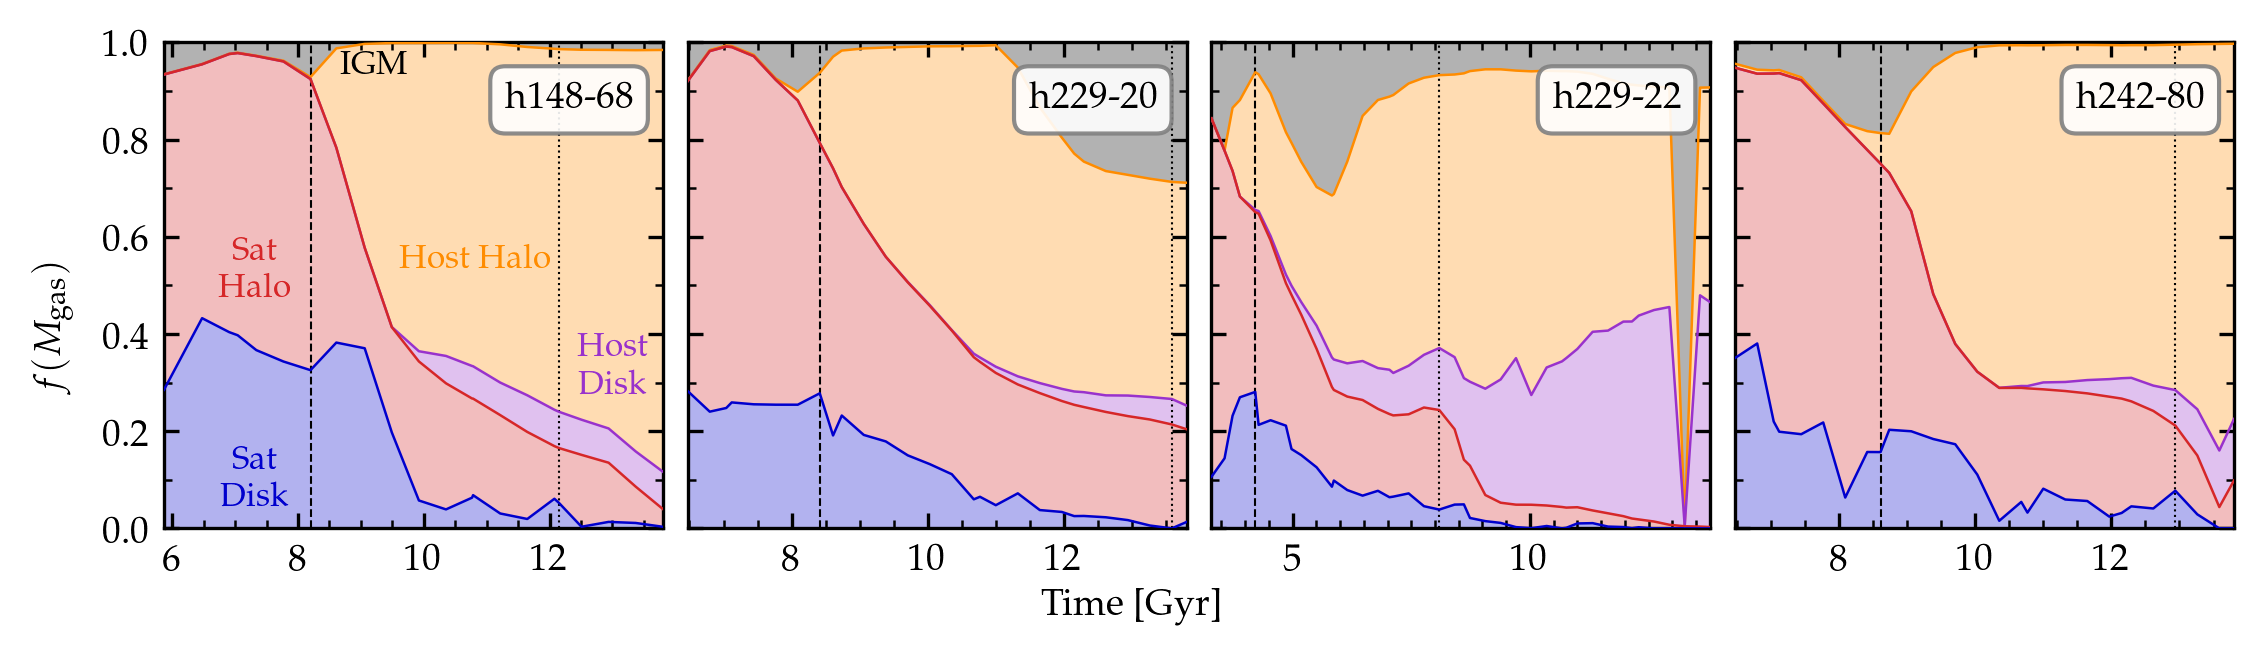

In [49]:
keys = ['h242_24', 'h148_13', 'h148_28', 'h148_37', 'h148_68', 'h229_20', 'h229_22', 'h242_80']

fig = plt.figure(figsize=(7.5, 2), dpi=300)
gs = mpl.gridspec.GridSpec(nrows=1, ncols=4, figure=fig)
gs.update(wspace=0.05, top=0.98, right=0.99, left=0.07, bottom=0.17)

ax0,ax1,ax2,ax3 = plt.subplot(gs[0]),plt.subplot(gs[1]),plt.subplot(gs[2]),plt.subplot(gs[3])

fill_fractions_ax(keys[0],ax0, label=True)
fill_fractions_ax(keys[1],ax1)
fill_fractions_ax(keys[2],ax2)
fill_fractions_ax(keys[3],ax3)

fig.text(0.5, 0.04, 'Time [Gyr]', ha='center', va='center')
fig.text(0.02, 0.5, r'$f(M_{\rm gas})$', ha='center', va='center', rotation='vertical')

plt.savefig(f'plots/fractions/fractions_1.pdf')
plt.show()

fig = plt.figure(figsize=(7.5, 2), dpi=300)
gs = mpl.gridspec.GridSpec(nrows=1, ncols=4, figure=fig)
gs.update(wspace=0.05, top=0.98, right=0.99, left=0.07, bottom=0.17)

ax0,ax1,ax2,ax3 = plt.subplot(gs[0]),plt.subplot(gs[1]),plt.subplot(gs[2]),plt.subplot(gs[3])

fill_fractions_ax(keys[4],ax0, label=True)
fill_fractions_ax(keys[5],ax1)
fill_fractions_ax(keys[6],ax2)
fill_fractions_ax(keys[7],ax3)

fig.text(0.5, 0.04, 'Time [Gyr]', ha='center', va='center')
fig.text(0.02, 0.5, r'$f(M_{\rm gas})$', ha='center', va='center', rotation='vertical')

plt.savefig(f'plots/fractions/fractions_2.pdf')
plt.show()

## rates of transfer between different states

We start by creating a new dataframe called `transfers` in which we will store particle-level data for particles that transfer between different states.

In [152]:
transfers = pd.DataFrame(columns = ['t1','t2','between','mass'])

In [190]:
# loop through every particle
for pid in tqdm.tqdm(pids):
    dat = data[data.pid==pid]
    times = np.array(dat.time)
    mass = np.array(dat.mass)
    coolontime = np.array(dat.coolontime)
    
    sat_disk = np.array(dat.sat_disk)
    sat_halo = np.array(dat.sat_halo)
    host_disk = np.array(dat.host_disk)
    host_halo = np.array(dat.host_halo)
    IGM = np.array(dat.IGM)
    
    for i,t2 in enumerate(times[1:]):
        i += 1
        t1 = times[i-1]
        if sat_disk[i-1] and sat_halo[i]:
            between = 'satdisk_sathalo'
        elif sat_halo[i-1] and sat_disk[i]:
            between = 'sathalo_satdisk'
        elif sat_halo[i-1] and host_halo[i]:
            between = 'sathalo_hosthalo'
        elif host_halo[i-1] and sat_halo[i]:
            between = 'hosthalo_sathalo'
        elif host_halo[i-1] and host_disk[i]:
            betewen = 'hosthalo_hostdisk'
        elif host_halo[i-1] and IGM[i]:
            between = 'hosthalo_IGM'
        elif host_disk[i-1] and host_halo[i]:
            between = 'hostdisk_hosthalo'
        elif IGM[i-1] and host_halo[i]:
            between = 'IGM_hosthalo'
        else: # a transfer we aren't interested in 
            continue
            
        outdict = {'t1':[t1], 't2':[t2], 'between':[between], 'mass':[mass[i]], 'coolontime':[coolontime[i]]}
        transfers = pd.concat([transfers, pd.DataFrame(outdict)])
        
transfers['delta_t'] = transfers.t2 - transfers.t1
transfers['massrate'] = transfers.mass/transfers.delta_t
transfers['SNe_aff'] = transfers.coolontime > transfers.t1 # use t1 to determine if it was expelled but cooled quickly

100%|██████████| 10614/10614 [05:55<00:00, 29.86it/s]


In [191]:
transfers.head()

,t1,t2,between,mass,coolontime,delta_t,massrate,SNe_aff
0,7.120602,7.443837,hosthalo_sathalo,26510.536704,0.000000,0.323235,82016.221337,False
0,10.029719,10.352954,sathalo_hosthalo,26510.543612,0.000000,0.323235,82016.242709,False
0,8.090307,8.413543,hosthalo_sathalo,33820.794348,4.999814,0.323235,104632.123672,False
0,9.383249,9.706484,sathalo_hosthalo,33820.794348,4.999814,0.323235,104632.123673,False
0,5.181190,5.504425,IGM_hosthalo,26510.536704,0.000000,0.323235,82016.221337,False


Now we need to compute transfer *rates* from this dataframe. We do this using the handy `groupby` function in `pandas`, which will group the particle dataset by common times and transfer states and sum the mass transfer rate for that transfer at that time.

In [192]:
rates = transfers.groupby(['t2','between'])['massrate'].sum()
rates = pd.DataFrame(rates).reset_index()
rates.head()

,t2,between,massrate
0,5.504425,IGM_hosthalo,2.460487e+05
1,5.504425,satdisk_sathalo,2.852563e+08
2,5.504425,sathalo_satdisk,1.554849e+08
3,5.827660,satdisk_sathalo,1.753597e+08
4,5.827660,sathalo_satdisk,1.969003e+08


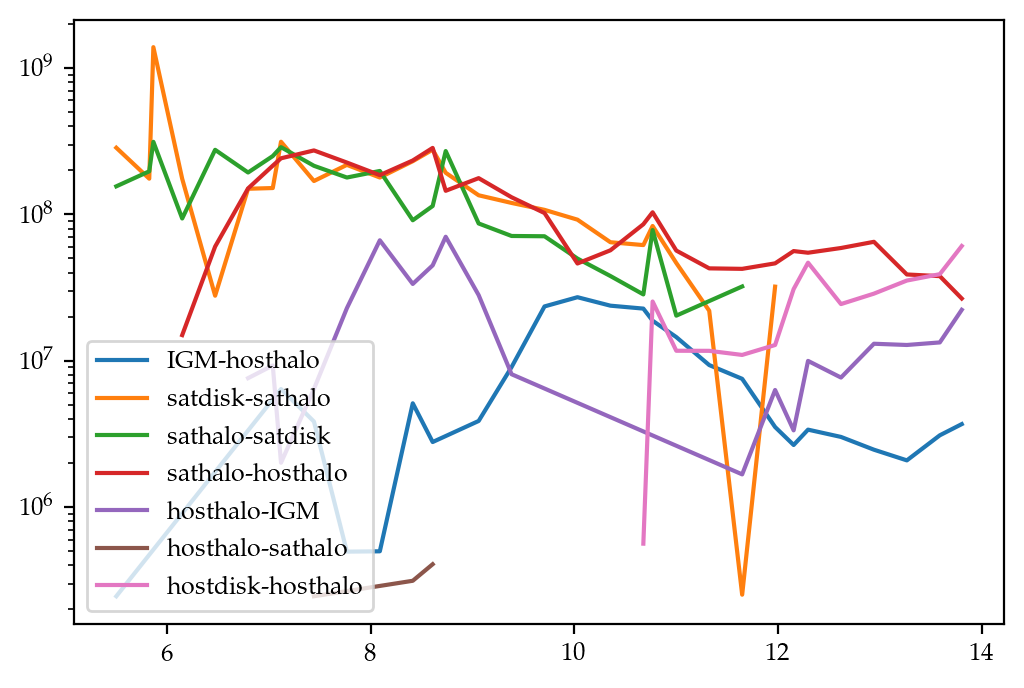

In [193]:
plt.figure(dpi=200)

# could use a dict to create labels from between keys

for between in rates.between.unique():
    r = rates[rates.between==between]
    label = between.replace('_','-')
    plt.plot(r.t2, r.massrate, label=label)
    
plt.semilogy()
plt.legend()
plt.show()

In [202]:
rates = transfers.groupby(['between','SNe_aff'],dropna=False)['mass'].sum()
rates = pd.DataFrame(rates).reset_index()
rates['between2'] = [b.replace('_','-') for b in rates.between]
rates

,between,SNe_aff,mass,between2
0,IGM_hosthalo,False,5.682563e+07,IGM-hosthalo
1,hostdisk_hosthalo,False,3.268786e+07,hostdisk-hosthalo
2,hostdisk_hosthalo,True,5.051426e+07,hostdisk-hosthalo
3,hosthalo_IGM,False,1.006713e+08,hosthalo-IGM
4,hosthalo_sathalo,False,2.605256e+05,hosthalo-sathalo
5,satdisk_sathalo,False,6.669433e+08,satdisk-sathalo
6,satdisk_sathalo,True,2.664723e+08,satdisk-sathalo
7,sathalo_hosthalo,False,8.443743e+08,sathalo-hosthalo
8,sathalo_hosthalo,True,1.758133e+07,sathalo-hosthalo
9,sathalo_satdisk,False,7.373137e+08,sathalo-satdisk


In [203]:
rates1 = rates[~rates.SNe_aff]
rates2 = rates[rates.SNe_aff]

joined = rates1.join(rates2.set_index('between'), on='between', lsuffix='_notsne', rsuffix='_sne')
joined

,between,SNe_aff_notsne,mass_notsne,between2_notsne,SNe_aff_sne,mass_sne,between2_sne
0,IGM_hosthalo,False,5.682563e+07,IGM-hosthalo,NaN,NaN,NaN
1,hostdisk_hosthalo,False,3.268786e+07,hostdisk-hosthalo,True,5.051426e+07,hostdisk-hosthalo
3,hosthalo_IGM,False,1.006713e+08,hosthalo-IGM,NaN,NaN,NaN
4,hosthalo_sathalo,False,2.605256e+05,hosthalo-sathalo,NaN,NaN,NaN
5,satdisk_sathalo,False,6.669433e+08,satdisk-sathalo,True,2.664723e+08,satdisk-sathalo
7,sathalo_hosthalo,False,8.443743e+08,sathalo-hosthalo,True,1.758133e+07,sathalo-hosthalo
9,sathalo_satdisk,False,7.373137e+08,sathalo-satdisk,True,6.265108e+07,sathalo-satdisk


/Users/hollis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  from ipykernel import kernelapp as app


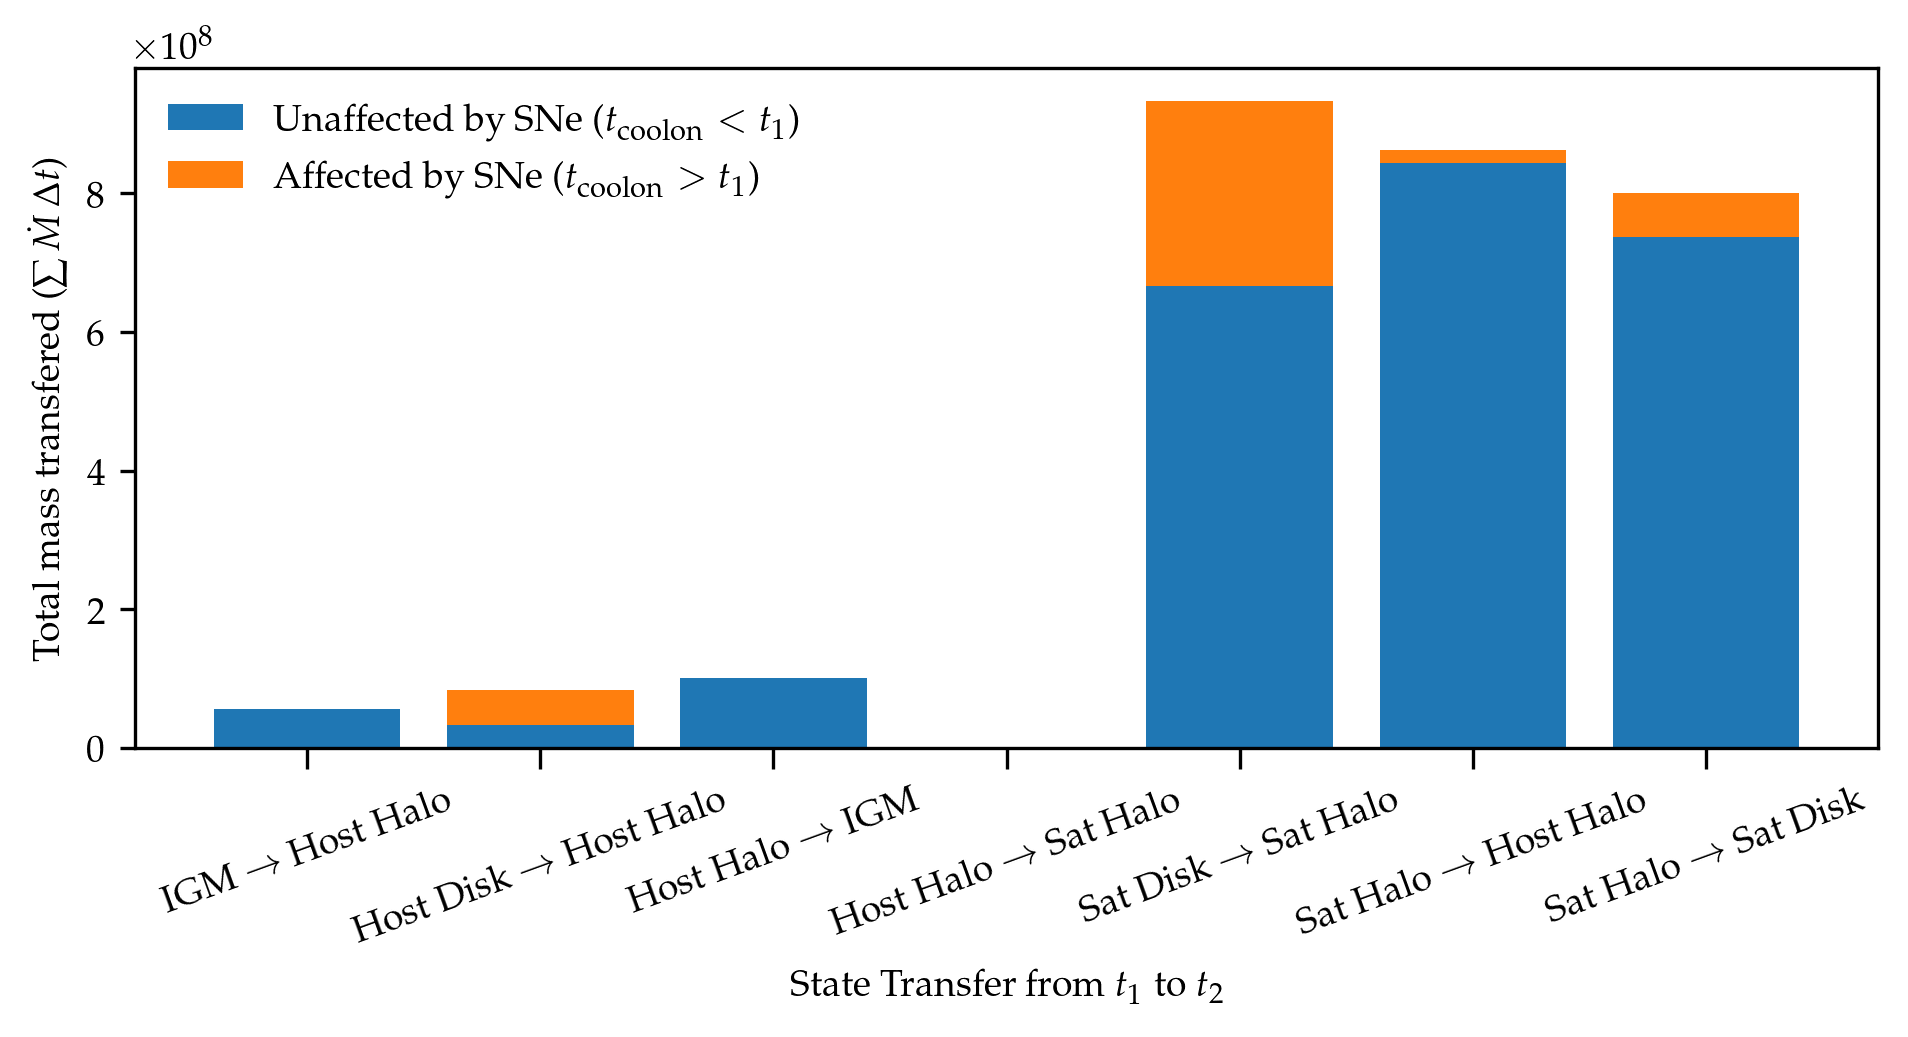

In [217]:
plt.figure(figsize=(7.5,3),dpi=300)

plt.bar(joined.between2_notsne, joined.mass_notsne, 
        label=r'Unaffected by SNe ($t_{\rm coolon} < t_1$)')

plt.bar(joined.between2_notsne, joined.mass_sne, bottom=joined.mass_notsne, 
        label=r'Affected by SNe ($t_{\rm coolon} > t_1$)')

# plt.semilogy()
plt.xlabel('State Transfer from $t_1$ to $t_2$')
plt.ylabel(r'Total mass transfered ($\sum \dot{M}\, \Delta t$)')
plt.gca().set_xticklabels([r'IGM $\to$ Host Halo',r'Host Disk $\to$ Host Halo',
                           r'Host Halo $\to$ IGM',r'Host Halo $\to$ Sat Halo',
                           r'Sat Disk $\to$ Sat Halo',r'Sat Halo $\to$ Host Halo',
                           r'Sat Halo $\to$ Sat Disk'])
plt.xticks(rotation=20)
plt.gca().tick_params(axis='x',length=5)
plt.legend(frameon=False)
# plt.ylim(1e5,2e9)
plt.show()

In [232]:
transfers['coolontime_diff'] = transfers.coolontime - transfers.t1
transfers2 = transfers[(transfers.between=='satdisk_sathalo')&(transfers.SNe_aff)]

In [233]:
transfers2.coolontime_diff

0    0.067013
0    0.113311
0    0.119902
0    0.260626
0    0.013149
       ...   
0    0.077117
0    0.071232
0    0.177292
0    0.047663
0    0.090428
Name: coolontime_diff, Length: 10404, dtype: float64

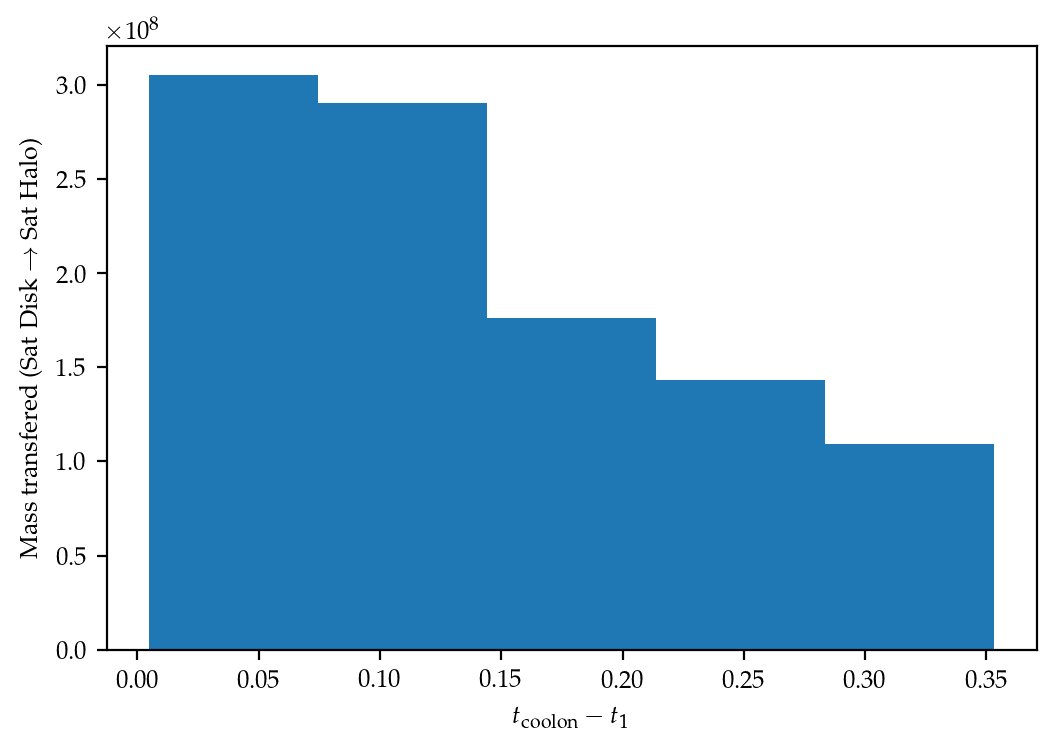

In [258]:
import scipy.stats

massrate, bin_edges, binnumber = scipy.stats.binned_statistic(transfers2.coolontime_diff, 
                                                              transfers2.massrate, 
                                                              statistic='sum',bins=5)
bin_widths = bin_edges[1:] - bin_edges[:-1]

plt.figure(dpi=200)
plt.bar(bin_edges[:-1], massrate, width=bin_widths, align='edge')

plt.xlabel(r'$t_{\rm coolon} - t_1$')
plt.ylabel(r'Mass transfered (Sat Disk $\to$ Sat Halo)')
plt.show()

### question I have yet to answer: is it common for gas particles to get ejected from satellite disk into satellite halo, then get stripped into the host halo? i.e. what is the delay time between those two events for a particle that eventually ends up in the host halo

## Grid of plots of gas fractions, transfer rates, and SFR

In [369]:
def plot_tinfall_tquench(key, axes):
    for ax in axes:
        timescales = read_timescales()
        sim = str(key[:4])
        haloid = int(key[5:])
        print(sim,haloid)
        t = timescales[(timescales.sim==sim)&(timescales.haloid==haloid)]
        tinfall = age - t.tinfall.squeeze()
        tquench = age - t.tquench.squeeze()
        ax.plot([tinfall,tinfall],[1e-13,1e13],linestyle='--', linewidth=0.5, color='k')
        ax.plot([tquench,tquench],[1e-13,1e13],linestyle=':', linewidth=0.5, color='k')

In [370]:
def fill_fractions_ax(key, ax, label=False):
    data = pd.read_hdf(path, key=key)

    # temporary
    data = data.rename(columns={'sat_disk': 'sat_disk_wrong', 'host_disk': 'host_disk_wrong',
                                'sat_halo': 'sat_halo_wrong', 'host_halo': 'host_halo_wrong'})

    data['sat_disk'] = (data.rho >= 0.1) & (data.temp <= 1.2e4) & (data.r <= 3)
    data['sat_halo'] = (data.r_per_Rvir < 1) & ~data.sat_disk
    data['host_disk'] = (data.rho >= 0.1) & (data.temp <= 1.2e4) & (data.r_per_Rvir > 1) & (data.h1dist < 0.1)
    data['host_halo'] = (data.r_per_Rvir > 1) & (data.h1dist < 1) & ~data.host_disk

    times = np.unique(data.time)

    frac_satdisk,frac_sathalo,frac_hostdisk,frac_hosthalo,frac_IGM = np.array([]),np.array([]),np.array([]),np.array([]),np.array([])

    for t in times:
        d = data[data.time==t]
        frac_satdisk = np.append(frac_satdisk,np.sum(d.mass[d.sat_disk])/np.sum(d.mass))
        frac_sathalo = np.append(frac_sathalo,np.sum(d.mass[d.sat_halo])/np.sum(d.mass))
        frac_hostdisk = np.append(frac_hostdisk,np.sum(d.mass[d.host_disk])/np.sum(d.mass))
        frac_hosthalo = np.append(frac_hosthalo,np.sum(d.mass[d.host_halo])/np.sum(d.mass))
        frac_IGM = np.append(frac_IGM,np.sum(d.mass[d.IGM])/np.sum(d.mass))

    frac_lost = 1 - (frac_satdisk+frac_sathalo+frac_hostdisk+frac_hosthalo+frac_IGM)


    lw = 0.6
    alpha = 0.3
    fontsize = 8
    colors = ['mediumblue', 'tab:red', 'darkorchid', 'darkorange', 'k']

    ax.fill_between(times, 0, frac_satdisk,fc=colors[0], alpha=alpha)
    ax.plot(times, frac_satdisk, color=colors[0], linewidth=lw, zorder=6)

    ax.fill_between(times, frac_satdisk, frac_satdisk+frac_sathalo, fc=colors[1], alpha=alpha)
    ax.plot(times, frac_satdisk+frac_sathalo, color=colors[1], linewidth=lw, zorder=5)

    ax.fill_between(times, frac_satdisk+frac_sathalo, frac_satdisk+frac_sathalo+frac_hostdisk, fc=colors[2], alpha=alpha)
    ax.plot(times, frac_satdisk+frac_sathalo+frac_hostdisk, color=colors[2], linewidth=lw, zorder=4)

    ax.fill_between(times, frac_satdisk+frac_sathalo+frac_hostdisk, frac_satdisk+frac_sathalo+frac_hostdisk+frac_hosthalo, fc=colors[3], alpha=alpha)
    ax.plot(times, frac_satdisk+frac_sathalo+frac_hostdisk+frac_hosthalo, color=colors[3], linewidth=lw, zorder=3)

    ax.fill_between(times, frac_satdisk+frac_sathalo+frac_hostdisk+frac_hosthalo,frac_satdisk+frac_sathalo+frac_hostdisk+frac_hosthalo+frac_IGM, fc=colors[4], alpha=alpha)
    ax.plot(times, frac_satdisk+frac_sathalo+frac_hostdisk+frac_hosthalo+frac_IGM, color=colors[4], linewidth=lw, zorder=2)



    ax.set_xlim(min(times),max(times))
    ax.set_ylim(0,1)

    if label:
        if key=='h242_24':
            ax.annotate('Sat \n Disk',(7.3,0.08),ha='center', va='center', color=colors[0], size=fontsize)
            ax.annotate('Sat \n Halo',(6.7,0.5),ha='center', va='center', color=colors[1], size=fontsize)
            ax.annotate('Host \n Disk',(12.5,0.18),ha='center', va='center', color=colors[2], size=fontsize)
            ax.annotate('Host Halo',(12.2,0.55),ha='center', va='center', color=colors[3], size=fontsize)
            ax.annotate('IGM',(9.2,0.95),ha='center', va='center', color=colors[4], size=fontsize)
        if key=='h148_68':
            ax.annotate('Sat \n Disk',(7.3,0.1),ha='center', va='center', color=colors[0], size=fontsize)
            ax.annotate('Sat \n Halo',(7.3,0.53),ha='center', va='center', color=colors[1], size=fontsize)
            ax.annotate('Host \n Disk',(13,0.33),ha='center', va='center', color=colors[2], size=fontsize)
            ax.annotate('Host Halo',(10.8,0.55),ha='center', va='center', color=colors[3], size=fontsize)
            ax.annotate('IGM',(9.2,0.95),ha='center', va='center', color=colors[4], size=fontsize)
    else:
        ax.tick_params(labelleft=False)

    ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.5))
    ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.1))
    ax.tick_params(direction='in', which='both', top=True,right=True)

    ax.annotate(key.replace('_','-'), (0.94, 0.92), xycoords='axes fraction', ha='right', va='top',
                bbox=dict(boxstyle='round,pad=0.4', fc='w', ec='0.5', alpha=0.9), zorder=100)

In [383]:
def fill_transfers_ax(key,ax):
    data = pd.read_hdf(path, key=key)

    # temporary
    data = data.rename(columns={'sat_disk': 'sat_disk_wrong', 'host_disk': 'host_disk_wrong',
                                'sat_halo': 'sat_halo_wrong', 'host_halo': 'host_halo_wrong'})

    data['sat_disk'] = (data.rho >= 0.1) & (data.temp <= 1.2e4) & (data.r <= 3)
    data['sat_halo'] = (data.r_per_Rvir < 1) & ~data.sat_disk
    data['host_disk'] = (data.rho >= 0.1) & (data.temp <= 1.2e4) & (data.r_per_Rvir > 1) & (data.h1dist < 0.1)
    data['host_halo'] = (data.r_per_Rvir > 1) & (data.h1dist < 1) & ~data.host_disk
    
    pids = np.unique(data.pid)
    
    transfers = pd.DataFrame(columns = ['t1','t2','between','mass'])
    
    # loop through every particle
    for pid in tqdm.tqdm(pids):
        dat = data[data.pid==pid]
        times = np.array(dat.time)
        mass = np.array(dat.mass)
        coolontime = np.array(dat.coolontime)

        sat_disk = np.array(dat.sat_disk)
        sat_halo = np.array(dat.sat_halo)
        host_disk = np.array(dat.host_disk)
        host_halo = np.array(dat.host_halo)
        IGM = np.array(dat.IGM)

        for i,t2 in enumerate(times[1:]):
            i += 1
            t1 = times[i-1]
            if sat_disk[i-1] and sat_halo[i]:
                between = 'satdisk_sathalo'
            elif sat_halo[i-1] and sat_disk[i]:
                between = 'sathalo_satdisk'
            elif sat_halo[i-1] and host_halo[i]:
                between = 'sathalo_hosthalo'
            elif host_halo[i-1] and sat_halo[i]:
                between = 'hosthalo_sathalo'
            elif host_halo[i-1] and host_disk[i]:
                betewen = 'hosthalo_hostdisk'
            elif host_halo[i-1] and IGM[i]:
                between = 'hosthalo_IGM'
            elif host_disk[i-1] and host_halo[i]:
                between = 'hostdisk_hosthalo'
            elif IGM[i-1] and host_halo[i]:
                between = 'IGM_hosthalo'
            else: # a transfer we aren't interested in 
                continue

            outdict = {'t1':[t1], 't2':[t2], 'between':[between], 'mass':[mass[i]], 'coolontime':[coolontime[i]]}
            transfers = pd.concat([transfers, pd.DataFrame(outdict)])

    transfers['delta_t'] = transfers.t2 - transfers.t1
    transfers['massrate'] = transfers.mass/transfers.delta_t
    transfers['SNe_aff'] = transfers.coolontime > transfers.t1 # use t1 to determine if it was expelled but cooled quickly
    

    rates = transfers.groupby(['t2','between'])['massrate'].sum()
    rates = pd.DataFrame(rates).reset_index()

    for between, colors in zip(['satdisk_sathalo','sathalo_satdisk','sathalo_hosthalo','hosthalo_sathalo'],
                               ['r','b','orange','purple']):
        r = rates[rates.between==between]
        label = between.replace('_','-')
        ax.plot(r.t2, r.massrate, label=label)

    ax.semilogy()
    #ax.legend(size=6)
    ax.set_ylim(1e5,5e9)
    

In [384]:
def read_timesteps(simname):
    '''Function to read in the timestep bulk-processing datafile (from /home/akinhol/Data/Timescales/DataFiles/{name}.data)'''
    data = []
    with open(f'../../Data/timesteps_data/{simname}.data','rb') as f:
        while True:
            try: 
                data.append(pickle.load(f))
            except EOFError:
                break
    
    data = pd.DataFrame(data)
    return data

def fill_sfr_ax(key, ax):
    '''Function to get the SFH from the z=0 data file, and plot. This should be fixed at some point, 
       since these SFHs are currently not using stellar formation masses but rather z=0 masses.'''
    # need to write a script to write lists of formation times and formation masses calculated using fsps probably
    data = pd.read_hdf('../../Data/sfhs.hdf5',key=key)
    tform = np.array(data.tform)
    massform = np.array(data.massform)
    
    bins = np.linspace(0, age, 100)
    bincenters = 0.5*(bins[1:]+bins[:-1])
    
    trange = [tform.min(), tform.max()]
    binnorm = 1e-9 * len(bins) / (trange[1] - trange[0])
    weights = massform*binnorm

    sfr, bins = np.histogram(tform, weights=weights, bins=bins)

    # get timestep data to spline fit mstar
    sim = str(key[:4])
    haloid = int(key[5:])
    timesteps = read_timesteps(sim)
    timesteps = timesteps[timesteps.z0haloid==haloid]
    time = np.flip(np.array(timesteps.time,dtype=float))
    mstar = np.flip(np.log10(np.array(timesteps.mstar,dtype=float)))
    

    
    from scipy.interpolate import UnivariateSpline
    w = np.isnan(mstar) | np.isinf(mstar)
    mstar[w] = 0.
    spl = UnivariateSpline(time,mstar, w = ~w)
    mstar_int = spl(bincenters)

    # get sSFR
    sSFR = sfr/np.power(10,mstar_int)
    
    ax.plot(bincenters, sSFR, linewidth=0.7)
    ax.semilogy()
    ax.set_ylim(1e-12,1e-9)
    


100%|██████████| 10614/10614 [01:10<00:00, 149.61it/s]
/Users/hollis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in log10
100%|██████████| 59286/59286 [30:11<00:00, 32.74it/s]
/Users/hollis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in log10
100%|██████████| 11143/11143 [01:08<00:00, 163.26it/s]
/Users/hollis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in log10


h242 24
h242 24
h242 24
h148 13
h148 13
h148 13
h148 28
h148 28
h148 28
h148 37
h148 37
h148 37


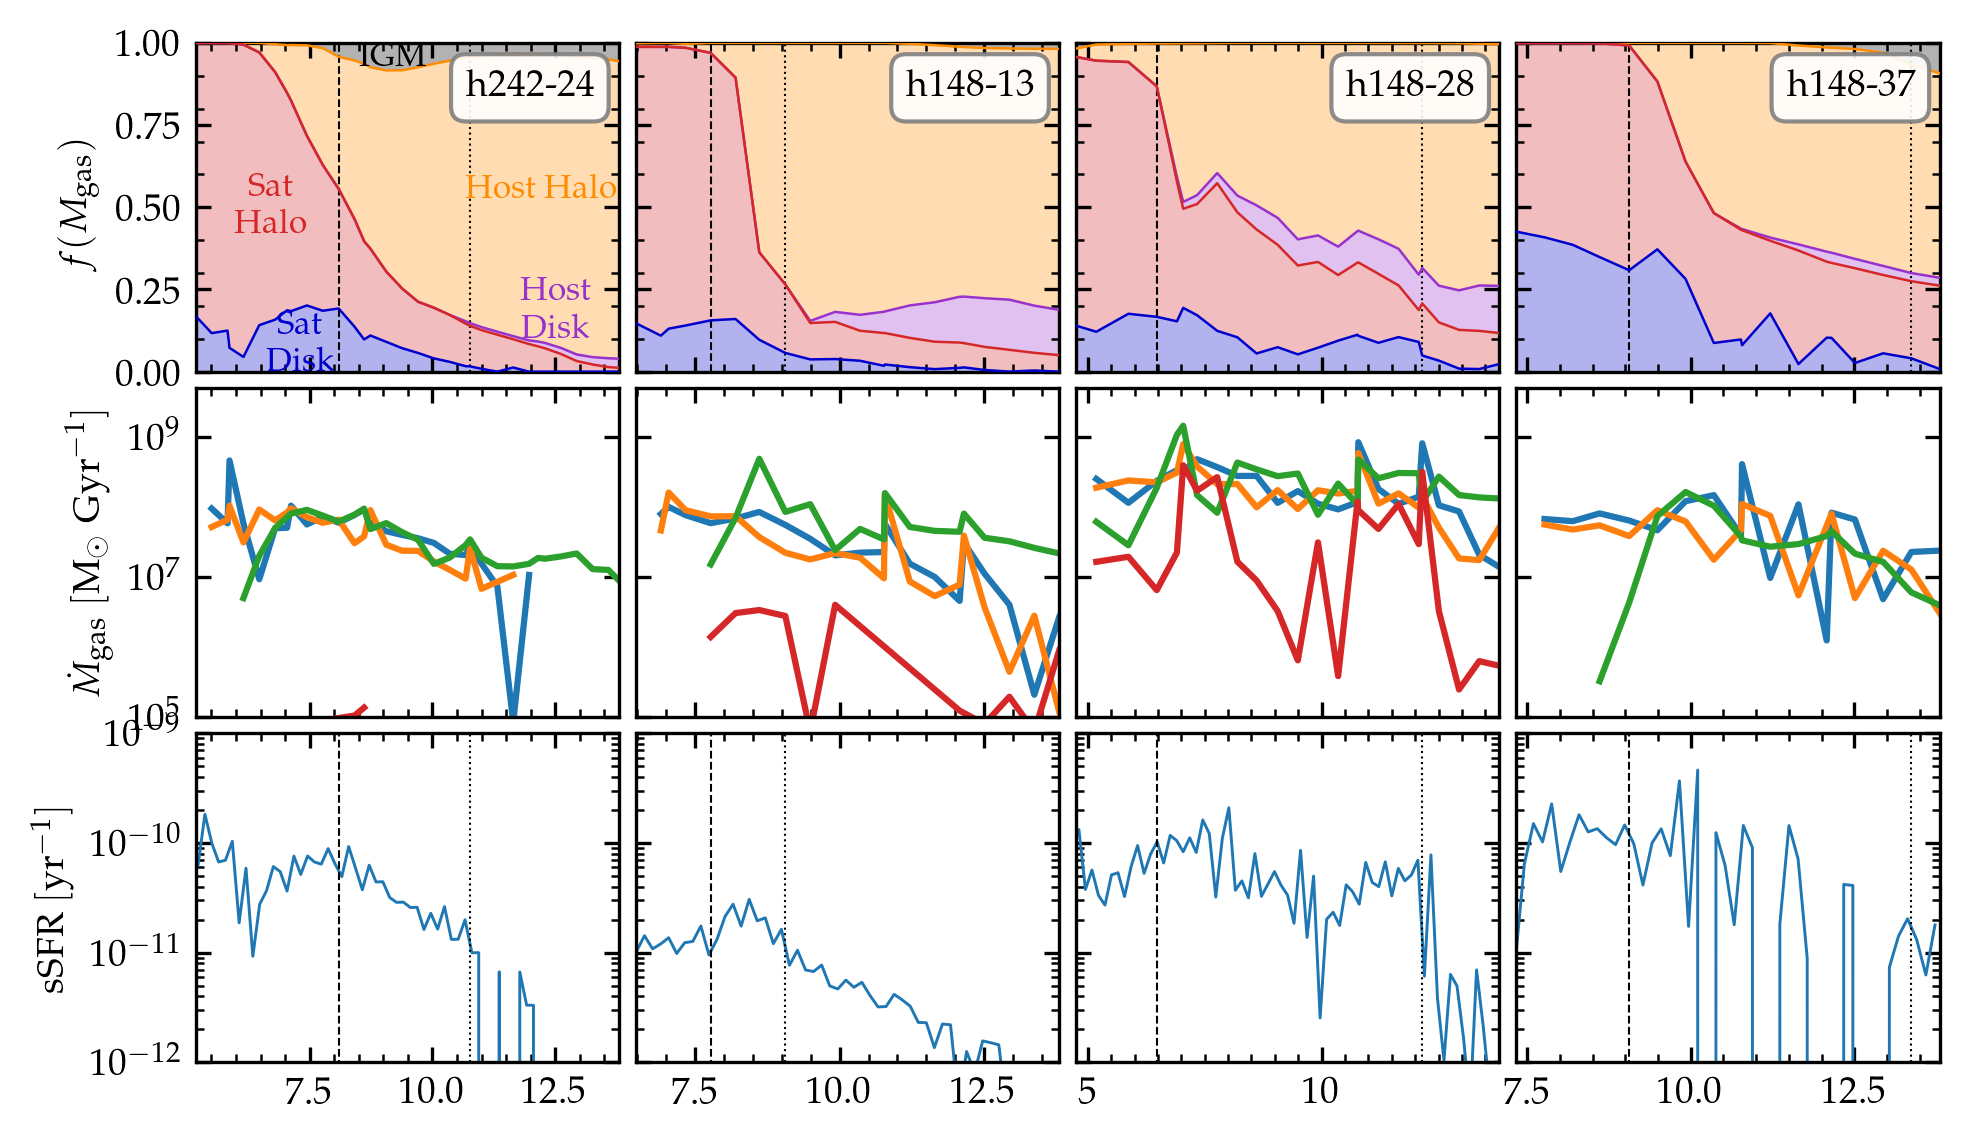

In [385]:
fig = plt.figure(figsize=(7.5,4.5),dpi=300)

gs = mpl.gridspec.GridSpec(nrows=3, ncols=4, figure=fig)
gs.update(hspace=0.05, wspace=0.04)

sat1_ax0 = plt.subplot(gs[0,0])
sat1_ax1 = plt.subplot(gs[1,0], sharex=sat1_ax0)
sat1_ax2 = plt.subplot(gs[2,0], sharex=sat1_ax1)

sat2_ax0 = plt.subplot(gs[0,1])
sat2_ax1 = plt.subplot(gs[1,1], sharex=sat2_ax0)
sat2_ax2 = plt.subplot(gs[2,1], sharex=sat2_ax1, sharey=sat1_ax2)

sat3_ax0 = plt.subplot(gs[0,2])
sat3_ax1 = plt.subplot(gs[1,2], sharex=sat3_ax0)
sat3_ax2 = plt.subplot(gs[2,2], sharex=sat3_ax1, sharey=sat2_ax2)

sat4_ax0 = plt.subplot(gs[0,3])
sat4_ax1 = plt.subplot(gs[1,3], sharex=sat4_ax0)
sat4_ax2 = plt.subplot(gs[2,3], sharex=sat4_ax1, sharey=sat3_ax2)

sat1_axes = [sat1_ax0, sat1_ax1, sat1_ax2]
sat2_axes = [sat2_ax0, sat2_ax1, sat2_ax2]
sat3_axes = [sat3_ax0, sat3_ax1, sat3_ax2]
sat4_axes = [sat4_ax0, sat4_ax1, sat4_ax2]
axes = np.array([sat1_axes,sat2_axes,sat3_axes,sat4_axes]).flatten()


keys = ['h242_24', 'h148_13', 'h148_28', 'h148_37', 'h148_68', 'h229_20', 'h229_22', 'h242_80']
fill_fractions_ax(keys[0],sat1_axes[0], label=True)
fill_transfers_ax(keys[0],sat1_axes[1])
fill_sfr_ax(keys[0],sat1_axes[2])

fill_fractions_ax(keys[1],sat2_axes[0], label=True)
fill_transfers_ax(keys[1],sat2_axes[1])
fill_sfr_ax(keys[1],sat2_axes[2])

fill_fractions_ax(keys[2],sat3_axes[0], label=True)
fill_transfers_ax(keys[2],sat3_axes[1])
fill_sfr_ax(keys[2],sat3_axes[2])

fill_fractions_ax(keys[3],sat4_axes[0], label=True)
fill_transfers_ax(keys[3],sat4_axes[1])
fill_sfr_ax(keys[3],sat4_axes[2])

plot_tinfall_tquench(keys[0],sat1_axes)
plot_tinfall_tquench(keys[1],sat2_axes)
plot_tinfall_tquench(keys[2],sat3_axes)
plot_tinfall_tquench(keys[3],sat4_axes)

for ax in axes:
    ax.tick_params(direction='in', which='both', right=True, top=True)

for ax in np.array([sat2_axes,sat3_axes,sat4_axes]).flatten():
    ax.tick_params(labelleft=False)
    
for ax in np.array([sat1_axes[:-1],sat2_axes[:-1],sat3_axes[:-1],sat4_axes[:-1]]).flatten():
    ax.tick_params(labelbottom=False)
    
sat1_axes[0].set_ylabel(r'$f(M_{\rm gas})$')
sat1_axes[1].set_ylabel(r'$\dot{M}_{\rm gas}~[\mathrm{M}_\odot~\mathrm{Gyr}^{-1}]$')
sat1_axes[2].set_ylabel(r'$\mathrm{sSFR}~[\mathrm{yr}^{-1}]$')

plt.show()

<font color='blue'>Blue</font>: sat disk to sat halo

<font color='orange'>Orange</font>: sat halo to sat disk

<font color='green'>Green</font>: sat halo to host halo

<font color='red'>Red</font>: host halo to sat halo

Transition between satellite disk and satellite halo is not as important as just exiting the disk at all

* check whether there are gas particles that go directly from satellite disk to host halo

Compare (anything to disk) to (satellite halo to disk) and compare (disk to anything) to (disk to satellite halo) 

Maybe plot orbits as another row

Satellite halo to host halo doesn't seem to have *much* to do with quenching

We see quenching pretty uniformly at a point where satellite halo gas reaching around 10 or 20 percent

Look at gas temperature and density in orbital trajectories --- can we subdivide halo and disk gas into other bins? 

Available keys: /h148_13 /h148_28 /h148_37 /h148_68 /h229_20 /h229_22 /h242_24 /h242_80


In [4]:
path = '../../Data/tracked_particles.hdf5'
key = 'h148_13'
data = pd.read_hdf(path, key=key)
data

# Temporary code to fix classification issue 
# (forgot to exclude disk particles from the halo in particletracking.py, so some were being classified in both)

data = data.rename(columns={'sat_disk': 'sat_disk_wrong',
                            'host_disk': 'host_disk_wrong',
                            'sat_halo': 'sat_halo_wrong',
                            'host_halo': 'host_halo_wrong'})

data['sat_disk'] = (data.rho >= 0.1) & (data.temp <= 1.2e4) & (data.r <= 3)
data['sat_halo'] = (data.r_per_Rvir < 1) & ~data.sat_disk
data['host_disk'] = (data.rho >= 0.1) & (data.temp <= 1.2e4) & (data.r_per_Rvir > 1) & (data.h1dist < 0.1)
data['host_halo'] = (data.r_per_Rvir > 1) & (data.h1dist < 1) & ~data.host_disk

data

,time,pid,rho,temp,mass,coolontime,r,r_per_Rvir,x,y,...,sat_disk_wrong,sat_halo_wrong,IGM,host_halo_wrong,host_disk_wrong,classification,sat_disk,sat_halo,host_disk,host_halo
0,6.474131,2202002,0.000050,619653.812500,27934.820603,1.502397,315.430011,4.000096,301.379304,38.695749,...,False,False,False,True,False,4.0,False,False,False,True
1,6.474131,2205223,0.000034,246611.796875,26567.141174,0.000000,345.770111,4.384851,283.107089,38.728024,...,False,False,False,True,False,4.0,False,False,False,True
2,6.474131,2857672,0.000074,708055.187500,26511.576364,0.000000,373.134629,4.731871,360.627617,-35.282347,...,False,False,False,True,False,4.0,False,False,False,True
3,6.474131,4057198,0.000023,405099.468750,26510.536704,0.000000,593.153339,7.522018,563.303480,-183.727503,...,False,False,False,True,False,4.0,False,False,False,True
4,6.474131,4073949,0.000024,405991.656250,26510.536704,0.000000,588.527236,7.463352,556.331718,-188.298945,...,False,False,False,True,False,4.0,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12447,13.800797,19009255,0.478361,733.537537,30288.071656,13.796250,284.462060,4.318511,49.714790,250.171752,...,False,False,False,True,True,4.0,False,False,True,False
12448,13.800797,19078060,0.000206,840771.562500,26645.618222,8.779381,390.337777,5.925844,67.699234,345.184330,...,False,False,False,True,False,4.0,False,False,False,True
12449,13.800797,19100998,0.000036,204305.203125,26859.950488,8.804634,85.520235,1.298310,-53.786871,36.639670,...,False,False,False,True,False,4.0,False,False,False,True
12450,13.800797,19103645,0.000005,238948.421875,28078.179678,11.644720,154.169322,2.340494,129.548087,-47.754756,...,False,False,False,True,False,4.0,False,False,False,True


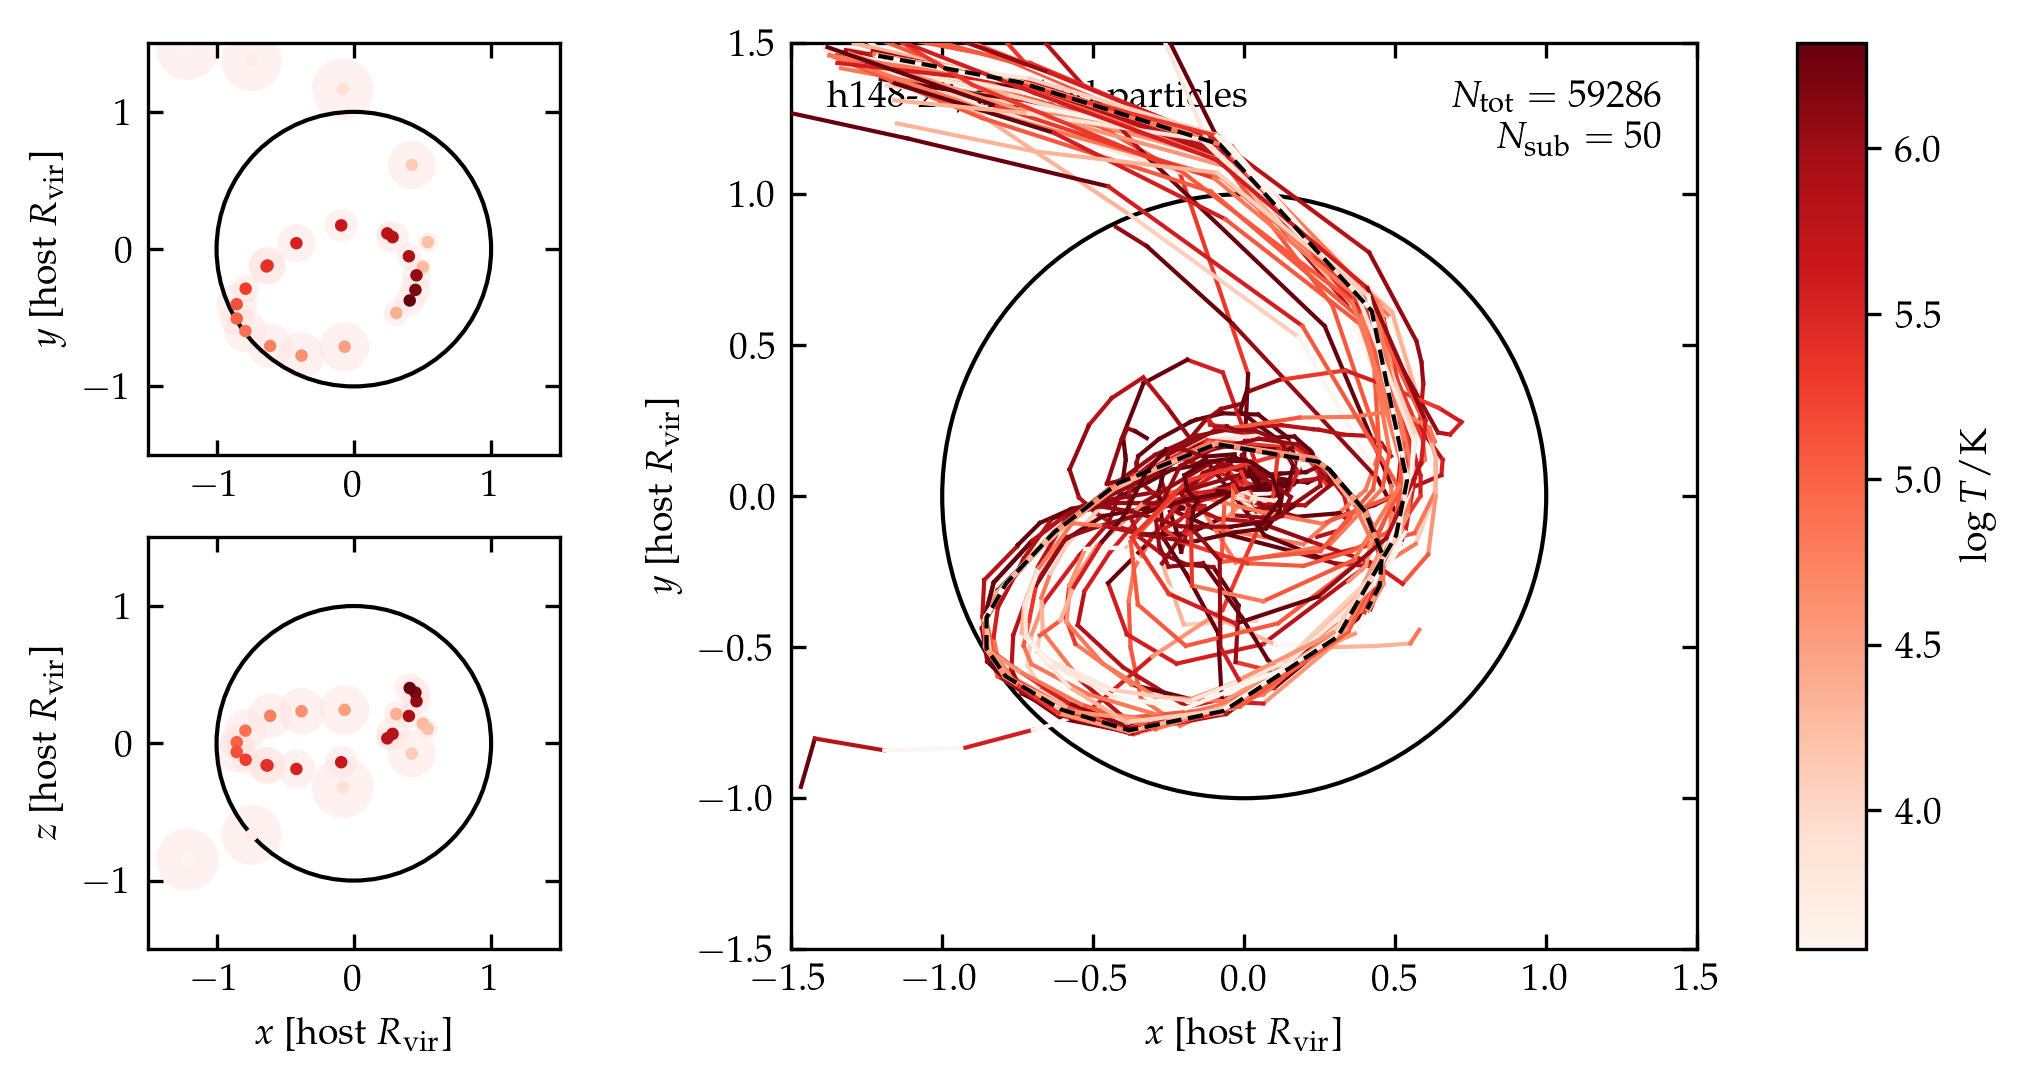

In [13]:
import astropy.units as u
from astropy.cosmology import Planck15, z_at_value

R = 1.5 # in Rvir, the maximum radius to plot 
N = 50 # number of particles to select in subsample

fig = plt.figure(dpi=300, figsize=(7.5,4))
gs = mpl.gridspec.GridSpec(2,5, width_ratios = [1,0.1,1,1,0.15], figure=fig)
ax0 = plt.subplot(gs[0,0])
ax1 = plt.subplot(gs[1,0])
ax2 = plt.subplot(gs[0:,2:-1])
cbax = plt.subplot(gs[:,-1])

host_radius = plt.Circle((0, 0), 1, color='k', fill=False)
ax0.add_artist(host_radius)

host_radius = plt.Circle((0, 0), 1, color='k', fill=False)
ax1.add_artist(host_radius)

host_radius = plt.Circle((0, 0), 1, color='k', fill=False)
ax2.add_artist(host_radius)

x_rel, y_rel, z_rel, Rvirs, ts = np.array([]),np.array([]),np.array([]),np.array([]),np.array([])
for t in np.unique(data.time):
    d = data[data.time==t]
    sat_x, sat_y, sat_z = np.mean(d.sat_Xc), np.mean(d.sat_Yc), np.mean(d.sat_Zc)
    host_x, host_y, host_z = np.mean(d.host_Xc), np.mean(d.host_Yc), np.mean(d.host_Zc)
    
    h1Rvir = np.mean(d.h1Rvir)
    satRvir = np.mean(d.satRvir)
    
    x_rel = np.append(x_rel, (sat_x-host_x)/h1Rvir)
    y_rel = np.append(y_rel, (sat_y-host_y)/h1Rvir)
    z_rel = np.append(z_rel, (sat_z-host_z)/h1Rvir)
    
    Rvirs = np.append(Rvirs, satRvir/h1Rvir*1100)
    
    radii = plt.Circle(((sat_x-host_x)/h1Rvir,(sat_y-host_y)/h1Rvir),
                     satRvir/h1Rvir, ec='none',fc='mistyrose', alpha=0.5, fill=True, zorder=0.5)
    ax0.add_artist(radii)
    
    radii = plt.Circle(((sat_x-host_x)/h1Rvir,(sat_z-host_z)/h1Rvir),
                     satRvir/h1Rvir, ec='none',fc='mistyrose', alpha=0.5, fill=True, zorder=0.5)
    ax1.add_artist(radii)
    
    ts = np.append(ts,t)
    
ax0.scatter(x_rel, y_rel, c=ts, cmap='Reds', s=4, zorder=2)
ax1.scatter(x_rel, z_rel, c=ts, cmap='Reds', s=4, zorder=2)
ax2.plot(x_rel, y_rel, 'k--', linewidth=1, zorder=1)
ax2.plot(x_rel, y_rel, 'k--', linewidth=1, zorder=1)
ax2.plot(x_rel, y_rel, 'k--', linewidth=1, zorder=1000)

pids = np.unique(data.pid)
np.random.seed(123)
pids_sub = np.random.choice(pids, size=N)

for j,pid in enumerate(pids_sub):
    d = data[data.pid==pid]
    
    cmap = mpl.cm.get_cmap('Reds', 12)
    tmin, tmax = np.min(np.log10(d.temp)), np.max(np.log10(d.temp))
    
    # Temporary code
    # x,y,z need to be scaled by the scale factor a
    # for now calculating a from t, but could pull this directly from the sim
    z = np.array([z_at_value(Planck15.age, (t-0.01)*u.Gyr) for t in d.time])
    a = 1/(1+z)
    
    i_prev = 0
    for i in range(len(d)-1):
        i += 1
        h1Rvir = list(d.h1Rvir)[i_prev]
        x1 = list(d.x_rel_host)[i_prev] / h1Rvir / a[i_prev]
        y1 = list(d.y_rel_host)[i_prev] / h1Rvir / a[i_prev]
        z1 = list(d.z_rel_host)[i_prev] / h1Rvir / a[i_prev]
        
        h1Rvir = list(d.h1Rvir)[i]
        x2 = list(d.x_rel_host)[i] / h1Rvir / a[i]
        y2 = list(d.y_rel_host)[i] / h1Rvir / a[i]
        z2 = list(d.z_rel_host)[i] / h1Rvir / a[i]
        t = np.log10(list(d.temp)[i])
        
        
        c = cmap((t-tmin)/(tmax-tmin))
        ax2.plot([x1,x2],[y1,y2],color=c, linewidth=1, zorder=j)

        i_prev = i
    
cb1 = mpl.colorbar.ColorbarBase(cbax, cmap=mpl.cm.Reds, orientation='vertical', 
                                norm = mpl.colors.Normalize(vmin=tmin, vmax=tmax),
                                label=r'$\log T/\mathrm{K}$')

ax1.set_xlabel(r'$x$ [host $R_{\rm vir}$]')
ax1.set_ylabel(r'$z$ [host $R_{\rm vir}$]')
ax0.set_ylabel(r'$y$ [host $R_{\rm vir}$]')
ax2.annotate(f"{key.replace('_','-')}, tracked particles", (0.04, 0.96), xycoords='axes fraction', va='top')
ax2.annotate(r'$N_{\rm tot} =$' + fr' ${len(pids)}$'+'\n'+r'$N_{\rm sub} =$' + fr' ${N}$', 
            (0.96, 0.96), xycoords='axes fraction', va='top', ha='right')

ax0.set_xlim(-R,R)
ax0.set_ylim(-R,R)
ax1.set_xlim(-R,R)
ax1.set_ylim(-R,R)
ax2.set_xlim(-R,R)
ax2.set_ylim(-R,R)

ax0.set_aspect('equal')
ax1.set_aspect('equal')
ax2.set_aspect('equal')

ax2.set_xlabel(r'$x$ [host $R_{\rm vir}$]')
ax2.set_ylabel(r'$y$ [host $R_{\rm vir}$]')


ax0.tick_params(top=True,right=True,direction='in', which='both')
ax1.tick_params(top=True,right=True,direction='in', which='both')
ax2.tick_params(top=True,right=True,direction='in', which='both')

# plt.savefig(f'plots/orbits/{key}_orbit.pdf')

plt.show()

In [350]:
sSFR

array([0.00000000e+00, 1.62682382e-11, 2.99206381e-11, 3.32856589e-09,
       1.25169774e-09, 1.05409315e-09, 1.23309979e-09, 9.95339631e-10,
       5.08106517e-10, 4.22051512e-10, 4.72190961e-10, 5.07864222e-10,
       8.31111990e-10, 4.46115073e-10, 3.48932080e-10, 3.06001015e-10,
       2.18473824e-10, 1.27400003e-10, 2.21414124e-10, 1.48448669e-10,
       1.32315171e-10, 1.85976856e-10, 1.50922839e-10, 1.50232677e-10,
       5.72343181e-11, 1.15167219e-10, 1.78042295e-10, 1.16741088e-10,
       1.17605824e-10, 1.07152149e-10, 5.60847808e-11, 9.51037103e-11,
       1.14665171e-10, 1.05467966e-10, 9.67336217e-11, 1.73342944e-10,
       2.14313348e-10, 6.27564795e-11, 1.82663768e-10, 9.99685540e-11,
       6.70284552e-11, 6.95660864e-11, 1.03507454e-10, 1.86881729e-11,
       5.88248013e-11, 9.23980039e-12, 2.75963310e-11, 3.66516958e-11,
       6.09073065e-11, 5.46953589e-11, 3.64274914e-11, 7.58792697e-11,
       5.16462980e-11, 7.60263224e-11, 6.70321558e-11, 6.41258215e-11,
      

In [197]:
r2

,t2,between,massrate,key
2,5.504425,sathalo_satdisk,5.182830e+07,55044
4,5.827660,sathalo_satdisk,6.563342e+07,58276
6,5.868065,sathalo_satdisk,1.043751e+08,58680
9,6.150896,sathalo_satdisk,3.125475e+07,61508
12,6.474131,sathalo_satdisk,9.203333e+07,64741
16,6.797366,sathalo_satdisk,6.441763e+07,67973
20,7.039793,sathalo_satdisk,8.341863e+07,70397
25,7.120602,sathalo_satdisk,9.596129e+07,71206
31,7.443837,sathalo_satdisk,7.157846e+07,74438
36,7.767072,sathalo_satdisk,5.951934e+07,77670


In [198]:
r1 = pd.DataFrame(rates[rates.between=='satdisk_sathalo']) # use pd.DataFrame to avoid writing back to rates
r2 = pd.DataFrame(rates[rates.between=='sathalo_satdisk'])
r1['key'] = pd.Series(r1.t2 * 10000, dtype=int)
r2['key'] = pd.Series(r2.t2 * 10000, dtype=int)

joined = r1.join(r2.set_index('key'), on='key', lsuffix='_r1', rsuffix='_r2', how='left')
joined

AttributeError: 'DataFrame' object has no attribute 't2'

In [ ]:
plt.figure(dpi=200)



plt.fill_between(joined.t2_r1, joined.massrate_r1, joined.massrate_r2, ec='none', fc='0.9', zorder=0, label='net')
plt.plot(r1.t2, r1.massrate, label='outflow')
plt.plot(r2.t2, r2.massrate, label='accretion')

plt.semilogy()
plt.legend()
plt.show()

## messing around with coordinate transformation idea

this code is bad and is just here because i don't want to delete it yet

In [6]:
pids = np.unique(data.pid)

np.random.seed(123)
pids_sub = np.random.choice(pids, size=50)

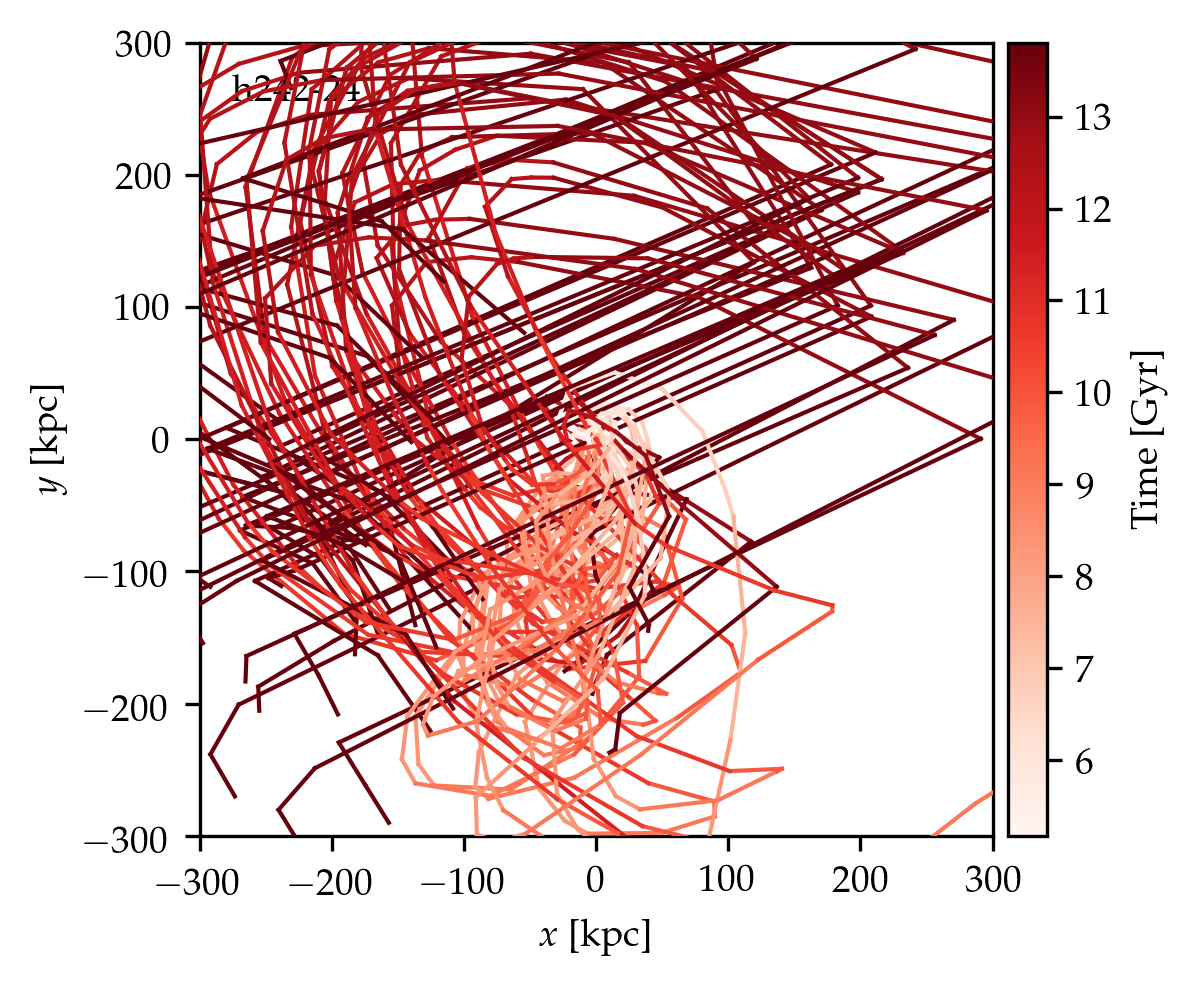

In [36]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
R = 300

fig, ax = plt.subplots(1,1,figsize=(4.2,3.5),dpi=300)
for j,pid in enumerate(pids_sub):
    d = data[data.pid==pid]
    
    cmap = mpl.cm.get_cmap('Reds', 12)
    tmin, tmax = np.min(d.time), np.max(d.time)
    
    i_prev = 0
    for i in range(len(d)-1):
        i += 1
        x1 = list(d.x)[i_prev]
        y1 = list(d.y)[i_prev]
        z1 = list(d.z)[i_prev]
        sat_v = np.array([list(d.sat_vx)[i_prev], list(d.sat_vy)[i_prev], list(d.sat_vz)[i_prev]])
        host_v = np.array([list(d.host_vx)[i_prev], list(d.host_vy)[i_prev], list(d.host_vz)[i_prev]])
        v1 = sat_v - host_v
        
        x2 = list(d.x)[i]
        y2 = list(d.y)[i]
        z2 = list(d.z)[i]
        sat_v = np.array([list(d.sat_vx)[i], list(d.sat_vy)[i], list(d.sat_vz)[i]])
        host_v = np.array([list(d.host_vx)[i], list(d.host_vy)[i], list(d.host_vz)[i]])
        v2 = sat_v - host_v
        t = list(d.time)[i]

        sat_p1 = np.array([list(d.sat_Xc)[i_prev], list(d.sat_Yc)[i_prev], list(d.sat_Zc)[i_prev]])
        host_p1 = np.array([list(d.host_Xc)[i_prev], list(d.host_Yc)[i_prev], list(d.host_Zc)[i_prev]])
        p1 = sat_p1 - host_p1
        
        sat_p2 = np.array([list(d.sat_Xc)[i], list(d.sat_Yc)[i], list(d.sat_Zc)[i]])
        host_p2 = np.array([list(d.host_Xc)[i], list(d.host_Yc)[i], list(d.host_Zc)[i]])
        p2 = sat_p2 - host_p2
        
        ### transformation code.... still not working quite right
        r1 = np.array([x1,y1,z1])
        r2 = np.array([x2,y2,z2])
        yhat = np.array([0,1,0])
        
        matr = rotation_matrix_from_vectors(yhat,v1)
        r1 = matr @ r1
        x1,y1,z1 = r1[0],r1[1],r1[2]
        
        matr = rotation_matrix_from_vectors(yhat,v2)
        r2 = matr @ r2
        x2,y2,z2 = r2[0],r2[1],r2[2]
        
        
        xhat = np.array([1,0,0])
        matr = rotation_matrix_from_vectors(xhat,p1)
        r1 = matr @ r1
        x1,y1,z1 = r1[0],r1[1],r1[2]

        matr = rotation_matrix_from_vectors(xhat,p2)
        r2 = matr @ r2
        x2,y2,z2 = r2[0],r2[1],r2[2]
        ###
        
        c = cmap((t-tmin)/(tmax-tmin))
                
        ax.plot([x1,x2],[y1,y2],color=c, linewidth=1, zorder=j)
        
#         if j == 0:
#             ax.arrow(0, 0, v_rel[0], v_rel[1], head_width=0.3, head_length=0.3, fc=c, ec=c, zorder=100+j)

        i_prev = i
    
    
divider = make_axes_locatable(ax)
ax_cb = divider.new_horizontal(size="5%", pad=0.05)    
cb1 = mpl.colorbar.ColorbarBase(ax_cb, cmap=mpl.cm.Reds, orientation='vertical', 
                                norm = mpl.colors.Normalize(vmin=tmin, vmax=tmax),
                                label='Time [Gyr]')
fig.add_axes(ax_cb)

    
ax.set_xlim(-R,R)
ax.set_ylim(-R,R)
ax.set_xlabel(r'$x$ [kpc]')
ax.set_ylabel(r'$y$ [kpc]')
ax.annotate(key.replace("_","-"), (0.04,0.96), xycoords='axes fraction', va='top')
ax.set_aspect('equal')


plt.show()

## Test code to transform coordinate system

In [33]:
v = np.array([12,-15,5])
r = np.array([0,0,1])*np.linalg.norm(v)

def rotation_matrix_from_vectors(vec1, vec2):
    """ Find the rotation matrix that aligns vec1 to vec2
    :param vec1: A 3d "source" vector
    :param vec2: A 3d "destination" vector
    :return mat: A transform matrix (3x3) which when applied to vec1, aligns it with vec2.
    """
    a, b = (vec1 / np.linalg.norm(vec1)).reshape(3), (vec2 / np.linalg.norm(vec2)).reshape(3)
    v = np.cross(a, b)
    c = np.dot(a, b)
    s = np.linalg.norm(v)
    kmat = np.array([[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]])
    rotation_matrix = np.eye(3) + kmat + kmat.dot(kmat) * ((1 - c) / (s ** 2))
    return rotation_matrix

matr = rotation_matrix_from_vectors(r,v)
out = matr @ np.array([1,0,0])

-12.0

## identifying gas particles that have just left the satellite halo

In [161]:
import tqdm
times = np.unique(data.time)

d_prev = data[data.time==times[0]]
# fix for now
prev_sat_disk = (d_prev.rho >= 0.1) & (d_prev.temp <= 1.2e4) & (d_prev.r <= 3)
prev_sat_halo = (d_prev.r_per_Rvir < 1) & ~prev_sat_disk

pids = np.unique(data.pid)
just_left = pd.DataFrame()
for pid in tqdm.tqdm(pids):
    dat = data[data.pid==pid]
    
    sat_disk = np.array((dat.rho >= 0.1) & (dat.temp <= 1.2e4) & (dat.r <= 3),dtype=bool)
    sat_halo = np.array((dat.r_per_Rvir < 1),dtype=bool) & ~sat_disk
    host_halo = np.array(dat.host_halo, dtype=bool)
    
    
    i = 0
    for t in dat.time:
        if i != 0:
            if sat_halo[i-1] and host_halo[i]:
                just_left = pd.concat([just_left,dat[dat.time==t]])
        
        i += 1

just_left

100%|██████████| 10614/10614 [00:47<00:00, 222.13it/s]


,time,pid,rho,temp,mass,coolontime,r,r_per_Rvir,x,y,...,host_Zc,host_vx,host_vy,host_vz,sat_disk,sat_halo,IGM,host_halo,host_disk,classification
0,10.352954,811077,0.000017,1.086080e+05,26510.543612,0.000000,57.487461,1.113112,-28.567391,-28.930443,...,26298.455502,107.09,179.88,28.91,False,False,False,True,False,4.0
1,9.706484,6872943,0.000063,2.498220e+04,33820.794348,4.999814,88.077183,1.683288,-49.520885,-45.805472,...,26273.698264,106.62,184.51,30.96,False,False,False,True,False,4.0
2,12.938837,8840402,0.000007,7.381693e+05,26262.456941,0.000000,64.293344,1.276252,-21.064121,60.718051,...,26366.003319,108.12,160.49,22.87,False,False,False,True,False,4.0
3,9.060013,8987571,0.000029,3.033766e+05,26510.536704,0.000000,76.806575,1.444267,35.561975,-67.273058,...,26240.281811,104.91,187.70,33.21,False,False,False,True,False,4.0
4,8.090307,9655109,0.000047,5.245932e+04,26510.536704,0.000000,69.771686,1.276218,18.291943,-67.237763,...,26185.166890,100.74,195.17,38.55,False,False,False,True,False,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10606,8.608831,10503018,0.000043,5.882960e+04,26510.536704,0.000000,66.364067,1.232179,14.630876,-62.546152,...,26216.386314,103.52,191.41,35.84,False,False,False,True,False,4.0
10607,8.736778,10503024,0.000037,1.475302e+05,26519.952361,0.000000,61.254605,1.141691,18.798251,-56.445181,...,26223.292507,103.95,190.36,34.85,False,False,False,True,False,4.0
10608,7.767072,10503746,0.000057,1.141102e+05,26657.753919,5.228853,81.288456,1.478098,25.040005,-77.326077,...,26168.397499,100.33,197.70,39.68,False,False,False,True,False,4.0
10609,8.413543,10505840,0.000020,1.170686e+06,27615.513779,7.211029,71.621509,1.321827,18.740840,-67.650754,...,26205.723216,102.78,192.77,37.96,False,False,False,True,False,4.0


Compute angle between the particle velocity vectors (measured relative to the satellite) and the bulk host velocity (measured relative to the satellite). The latter acts as a proxy for the CGM wind velocity, which we could compute later if we want to. 

If the exit angle (angle between these vectors) is generally around 0, then we know that the particles are generally moving the same direction as the CGM relative to the satellite, a clear signature of ram pressure stripping. If the angle is more uniformly distributed, the particles are leaving in every direction, a more clear signature of feedback or tidal stripping. 

In [208]:
just_left.keys()

Index(['time', 'pid', 'rho', 'temp', 'mass', 'coolontime', 'r', 'r_per_Rvir',
       'x', 'y', 'z', 'satRvir', 'vx', 'vy', 'vz', 'v', 'x_rel_host',
       'y_rel_host', 'z_rel_host', 'h1dist', 'h1Rvir', 'sat_Xc', 'sat_Yc',
       'sat_Zc', 'sat_vx', 'sat_vy', 'sat_vz', 'host_Xc', 'host_Yc', 'host_Zc',
       'host_vx', 'host_vy', 'host_vz', 'sat_disk', 'sat_halo', 'IGM',
       'host_halo', 'host_disk', 'classification'],
      dtype='object')

In [213]:
angles = np.array([])

for d in tqdm.tqdm(just_left.iterrows()):
    v = np.array([d[1].vx,d[1].vy,d[1].vz])
    v_sat = np.array([d[1].sat_vx,d[1].sat_vy,d[1].sat_vz])
    v_host = np.array([d[1].host_vx,d[1].host_vy,d[1].host_vz])
    v_rel = v_host - v_sat # different than usual
    
    v_hat = v / np.linalg.norm(v)
    v_rel_hat = v_rel / np.linalg.norm(v_rel)
    angle = np.arccos(np.dot(v_hat,v_rel_hat)) * 180/np.pi
    angles = np.append(angles,angle)

10482it [00:02, 4346.68it/s]


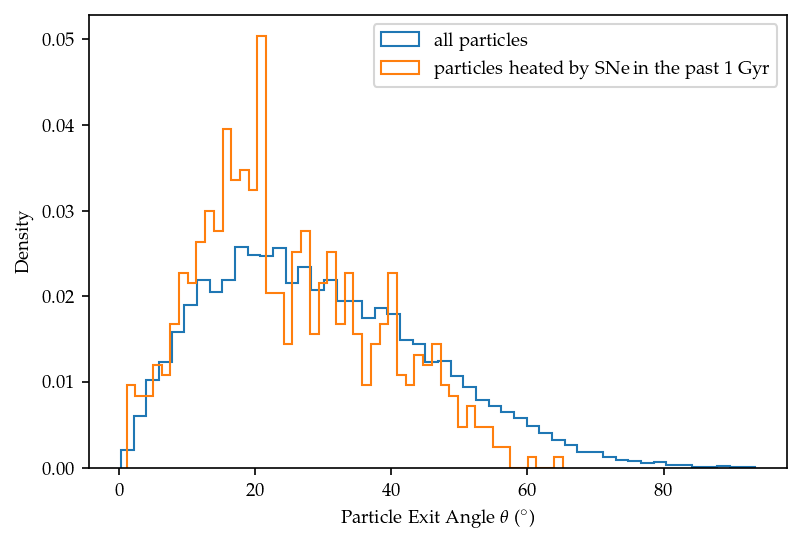

In [215]:
plt.figure(dpi=150)
plt.hist(angles, histtype='step', bins=50, density=True, label='all particles')

SNe_bool = np.array(just_left.coolontime > just_left.time - 1,dtype=bool)
plt.hist(angles[SNe_bool], histtype='step', bins=50, density=True, label='particles heated by SNe in the past 1 Gyr')

plt.xlabel(r'Particle Exit Angle $\theta$ ($^\circ$)')
plt.ylabel('Density')
plt.legend()
plt.show()

[ 5.18118989  8.05439242 10.92759496 13.8007975 ]


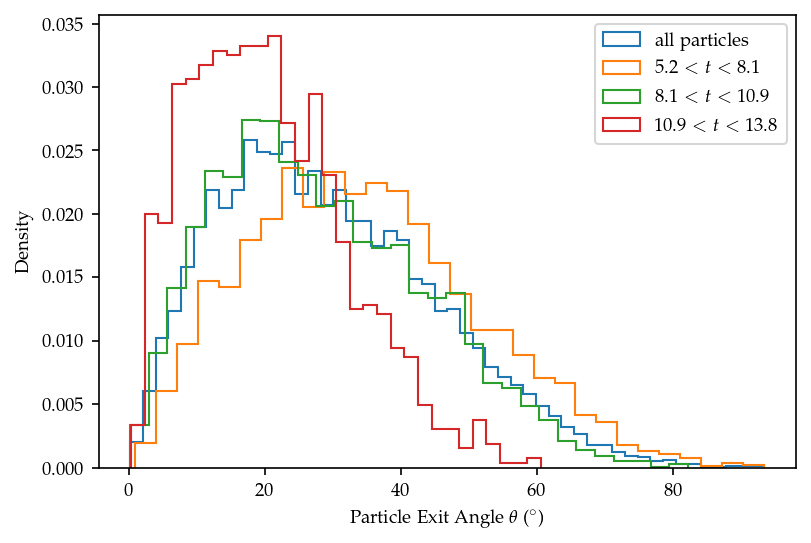

In [216]:
plt.figure(dpi=150)
plt.hist(angles, histtype='step', bins=50, density=True, label='all particles')

tbins = np.linspace(tmin,tmax,4)
print(tbins)
for t1,t2 in zip(tbins[:-1],tbins[1:]):
    plt.hist(angles[(just_left.time > t1)&(just_left.time < t2)], histtype='step', bins=30, density=True, label=fr'${t1:.1f} < t < {t2:.1f}$')

plt.xlabel(r'Particle Exit Angle $\theta$ ($^\circ$)')
plt.ylabel('Density')
plt.legend()
plt.show()

[0.66066025 0.89924687 1.13783348 1.37642009]


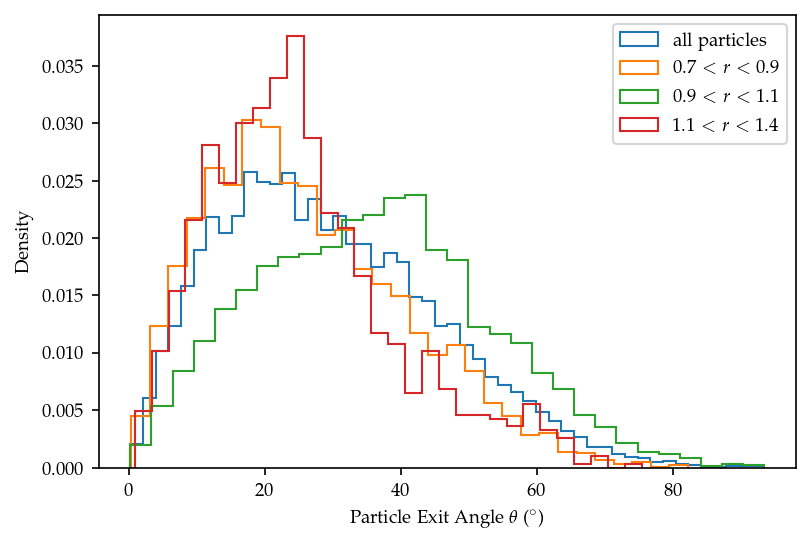

In [217]:
plt.figure(dpi=150)
plt.hist(angles, histtype='step', bins=50, density=True, label='all particles')

sat_h1dist = np.array([just_left.sat_Xc,just_left.sat_Yc,just_left.sat_Zc],dtype=float) - np.array([just_left.host_Xc,just_left.host_Yc,just_left.host_Zc],dtype=float)
sat_h1dist /= np.array(just_left.h1Rvir,dtype=float)
sat_h1dist = sat_h1dist.T
sat_h1dist = np.array([np.sqrt(np.sum(d**2)) for d in sat_h1dist])

rbins = np.linspace(np.min(sat_h1dist),np.max(sat_h1dist),4)
print(rbins)
for r1,r2 in zip(rbins[:-1],rbins[1:]):
    plt.hist(angles[(sat_h1dist > r1)&(sat_h1dist < r2)], histtype='step', bins=30, density=True, label=fr'${r1:.1f} < r < {r2:.1f}$')

plt.xlabel(r'Particle Exit Angle $\theta$ ($^\circ$)')
plt.ylabel('Density')
plt.legend()
plt.show()

## compute mass-loss rates etc

/Users/hollis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/Users/hollis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars


[  5.19155947   2.83738499 109.71459181   6.60140954   0.31170355
   2.39533584   2.49464891  13.47611855   2.43484526   3.77513227
   2.790965     7.83116762  12.41395073   5.55392185   4.8199653
   5.20185115   4.68606463   5.70607125   5.26424933   4.1331415
  13.25815256   5.59770942  56.33278928   0.                  inf
          nan          nan          nan          nan          nan
          nan          nan]


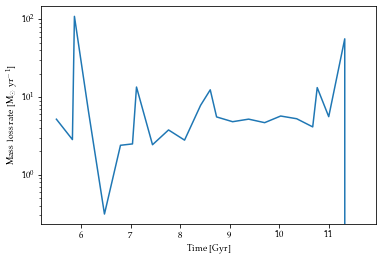

In [131]:
times = np.unique(data.time)

# start with: sat_halo to host_halo

# start with first snap tracked
d_prev = data[data.time==times[0]]
d_prev.sat_disk = (d_prev.rho >= 0.1) & (d_prev.temp <= 1.2e4) & (d_prev.r <= 3)
d_prev.sat_halo = (d_prev.r_per_Rvir < 1) & ~d_prev.sat_disk
t_prev = times[0]

mass_loss_rate = np.array([])
for t in times[1:]:
    d = data[data.time==t]

    d.sat_disk = (d.rho >= 0.1) & (d.temp <= 1.2e4) & (d.r <= 3)
    d.sat_halo = (d.r_per_Rvir < 1) & ~d.sat_disk
    
    # sorta hacky.... trying to make sure that we are accounting for loss of particles...
    d_prev = d_prev[np.isin(d_prev.pid, d.pid)]

    
    mass_lost = np.sum(d.mass[d_prev.sat_disk & d.sat_halo])/np.sum(d.mass[d_prev.sat_halo & d.sat_disk])
    mass_loss_rate = np.append(mass_loss_rate, mass_lost/(t-t_prev))
    

    #print(len(d.classification[np.array(d.classification)==np.array(d_prev.classification)])/len(d.classification))
    
    d_prev = d
    t_prev = t
    
print(mass_loss_rate)
plt.figure()
plt.plot(times[1:], mass_loss_rate)
plt.xlabel('Time [Gyr]')
plt.ylabel(r'Mass loss rate [M$_\odot$ yr$^{-1}$]')
plt.yscale('log')
plt.show()


In [78]:
mass_loss_rate

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])